In [416]:
from sqlalchemy import create_engine
import os
import pandas as pd
import numpy as np
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn_extra.cluster import KMedoids 

# Load Files

In [417]:
project_path = "/Users/hyunsubong/Library/CloudStorage/OneDrive-명지대학교/Univ/2022-1/테청캠/Code"
file_path = str(project_path) + "/datacampus_dao/preprocessing/files"
folder_list = [f for f in os.listdir(file_path) if not f.startswith('.')]

data_list = []
for i in folder_list:
    data = pd.read_csv(file_path + '/' + i, encoding="cp949")
#     print(data)
    data_list.append(data)

for idx, file in enumerate(folder_list):
    file = file.rstrip(".csv")
    folder_list[idx] = file
    
print("총 {}개의 파일을 불러왔습니다.\n".format(len(folder_list)))
print(folder_list)

총 24개의 파일을 불러왔습니다.

['overpass_knn2_median', 'overpass_mean_drop', 'overpass_knn1_drop', 'tunnel_knn1_drop', 'tunnel_mean_drop', 'tunnel_knn2_median', 'tunnel_knn5_median', 'overpass_knn5_median', 'overpass_mean_median', 'tunnel_knn3_median', 'tunnel_knn2_drop', 'tunnel_knn3_drop', 'tunnel_mean_median', 'overpass_knn3_median', 'overpass_knn2_drop', 'overpass_knn3_drop', 'overpass_knn5_drop', 'overpass_knn4_drop', 'overpass_knn4_median', 'tunnel_knn1_median', 'tunnel_knn4_median', 'overpass_knn1_median', 'tunnel_knn5_drop', 'tunnel_knn4_drop']


# 전처리

In [418]:
def preprocess_df(df, onehot_col=None, scaling_col=None, drop_col = None, labeling_col = None, scaling_func=MinMaxScaler) :
    """
    :param df: 사용할 데이터프레임 
    :param onehot_col: default = None, 원핫인코딩할 컬럼 리스트 
    :param scaling_col: default = None, 스케일링할 컬럼 리스트 
    :param drop_col: default = None, 사용하지 않을 컬럼 리스트 
    :param labeling_col: default = None, 라벨링이 필요한 컬럼 리스트 
    :param scaling_func: 스케일링시 사용할 컬럼, MinMaxScaler or StandardScaler
    :return: 전처리 된 데이터 프레임
    """
    if drop_col is not None :
        df = df.drop(drop_col, axis=1)
    if onehot_col is not None:
        df = pd.get_dummies(df, columns= onehot_col)
    if scaling_col is not None :
        for c in scaling_col :
            scaler = scaling_func()
            scaler.fit(df[[c]])
            df[c] = scaler.transform(df[[c]])
    if labeling_col is not None :
        for c in labeling_col :
            encoder = LabelEncoder()
            encoder.fit(df[c])
            df[c] = encoder.transform(df[c])
    return df

# Elbow Method(응집도) & Kmeans

In [419]:
# 응집도
def cal_num_of_cluster(df_list):
    for idx, target_df in enumerate(df_list):
        target_df = preprocess_df(target_df, scaling_col=scaling_col, onehot_col=onehot_col, drop_col=drop_col, scaling_func=MinMaxScaler)
        elbow_fitted = []
        for i in range(1,10):
            k_mean_elbow = KMeans(n_clusters = i , init = 'k-means++', n_init=15, max_iter = 150, random_state = 0)
            k_mean_elbow.fit(target_df)
            elbow_fitted.append(k_mean_elbow.inertia_)
        # preprocess_df 결과로 대치
        df_list[idx] = target_df
        # k_mean_elbow.fit 결과 리스트 추가
        elbow_inertias.append(elbow_fitted)

In [420]:
onehot_col = ['지형기호(2.3km)', '최우점식물군락']
scaling_col = ['주변 로드킬 빈도','폭(m)', '연장(m)', '산책로까지의 최단 거리(km)', '농가까지의 거리(km)', '도로 최고제한속도(km/h)', '하천거리(km)', '등산로까지 최단거리(km)', '유도울타리_연장_m', '유도울타리_높이_m', '교통량', '건물까지거리(km)']
drop_col = ['번호', '위도', '경도', '이용확인종_수', '유도울타리_위도_2.3km', '유도울타리_경도_2.3km', '식물군락명', '생태통로_유형', '생태통로_효율성']
elbow_inertias = []

cal_num_of_cluster(data_list)

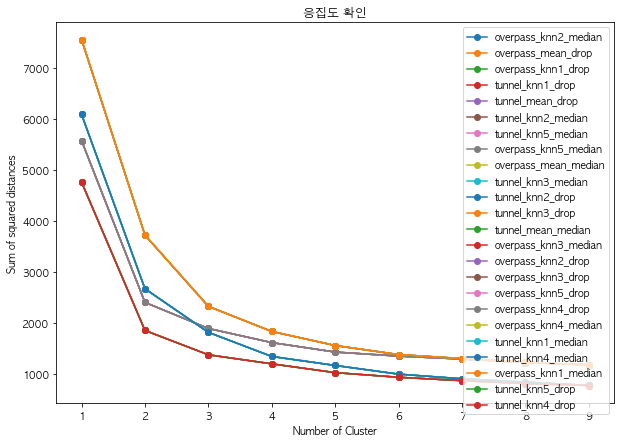

In [421]:
plt.figure(figsize=(10,7))
for idx, file_name in enumerate(folder_list):
    plt.plot(range(1,10), elbow_inertias[idx], marker = 'o', label = file_name)
plt.rcParams['font.family'] = 'AppleGothic'
plt.legend(loc='upper right')
plt.title("응집도 확인")
plt.xlabel('Number of Cluster')
plt.ylabel('Sum of squared distances')
plt.show()

# 최적의 군집 개수

In [422]:
def visualize_silhouette(num_clusters, X_features, data_idx, cluster_name = "KMeans"):     
    num_cluster = len(num_clusters)
    fig, axs = plt.subplots(figsize=(4 * num_cluster, 4), nrows = 1, ncols = num_cluster)
    fig.suptitle(cluster_name + '_' + folder_list[data_idx], fontsize = 20)
    for ind, n_cluster in enumerate(num_clusters):
        
        # 클러스터별 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = clusterer = KMeans(n_clusters = n_cluster, max_iter = 500, random_state = 0, init = 'k-means++')
        if cluster_name == "GaussianMixture":
            clusterer = GaussianMixture(n_components = n_cluster, random_state = 0)
        elif cluster_name == "KMedoids":
            clusterer = KMedoids(n_clusters = n_cluster, random_state=0, init = 'k-medoids++')
        elif cluster_name == "Hierarchical":
            clusterer = AgglomerativeClustering(n_clusters = n_cluster, affinity = "euclidean",linkage = 'ward')
        
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,5)),
                           fontsize = 15)
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # plot graph
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels == i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")
    plt.tight_layout()
    plt.savefig("최적의 군집 개수 (KMeans).png",dpi=300)

/var/folders/x5/p0qmykj10d194mw60zsdt6fm0000gn/T/ipykernel_6205/4226666199.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize=(4 * num_cluster, 4), nrows = 1, ncols = num_cluster)


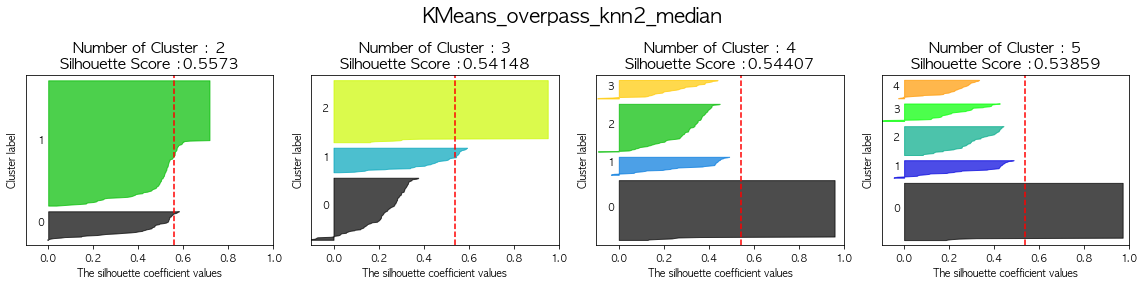

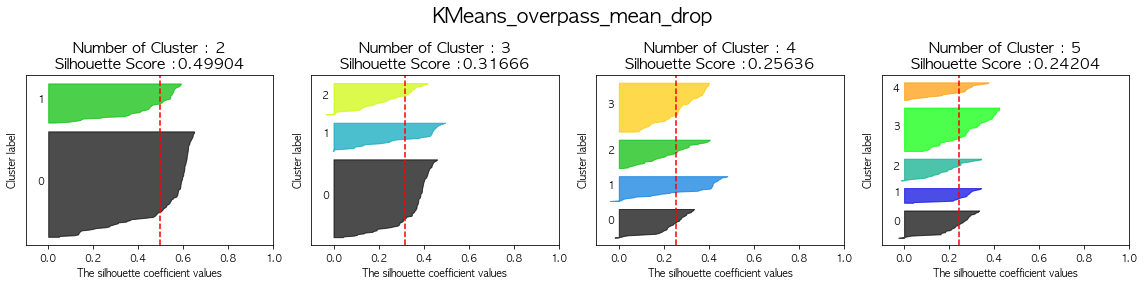

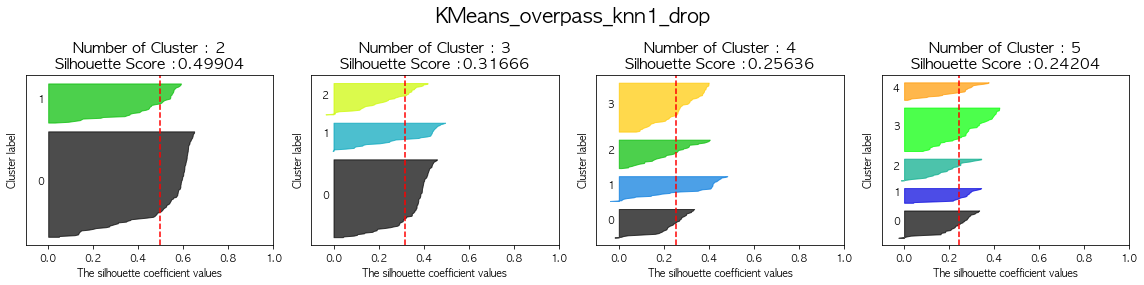

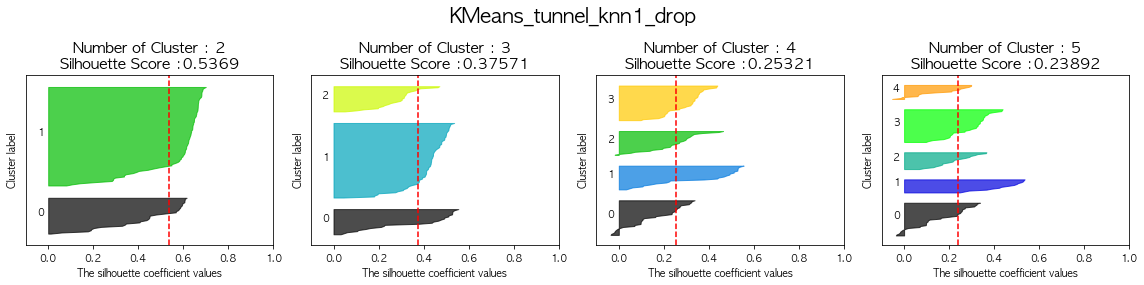

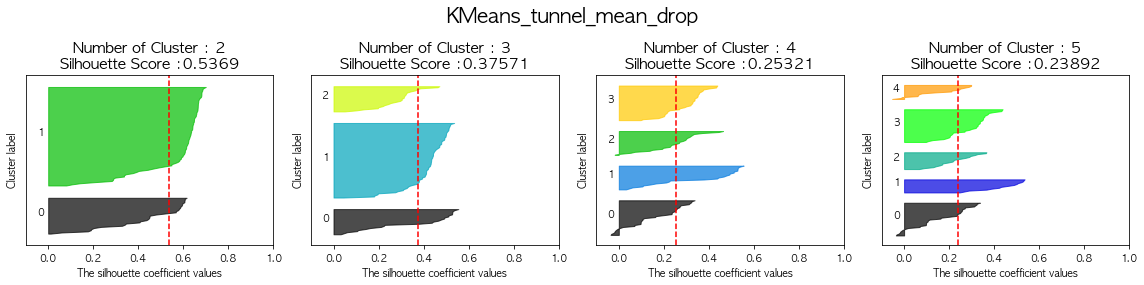

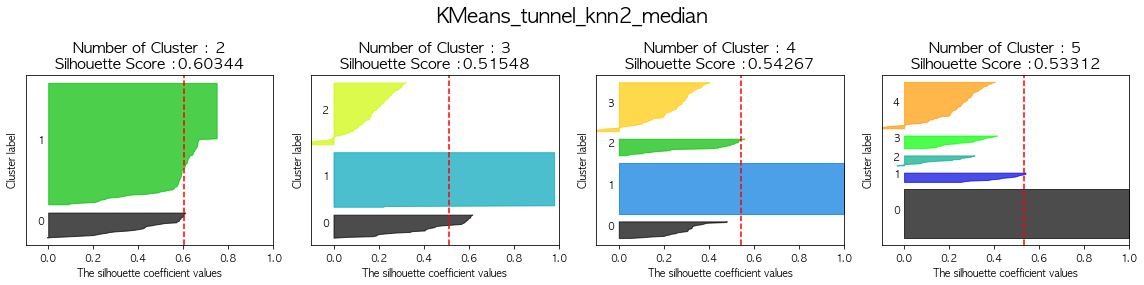

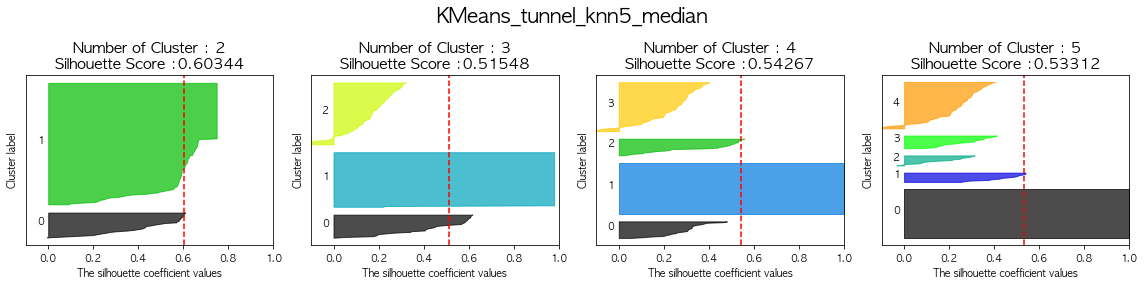

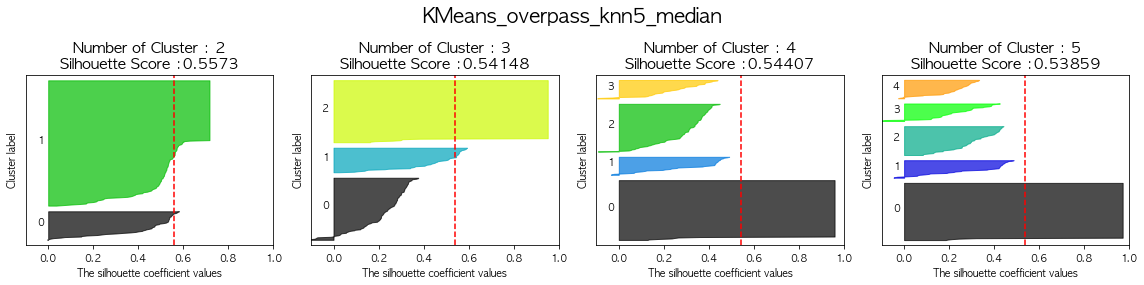

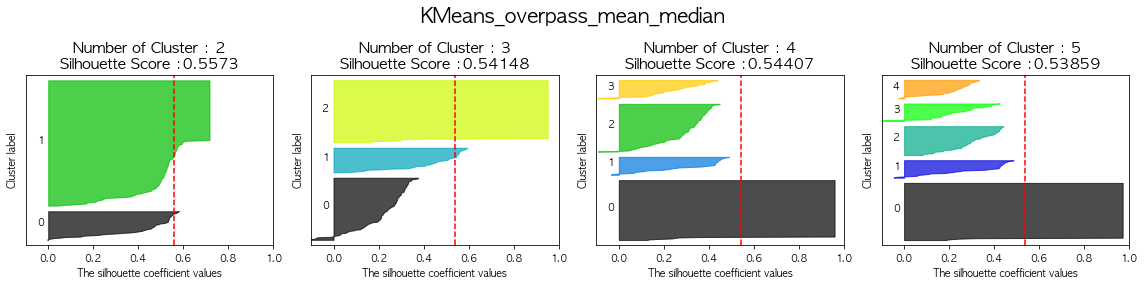

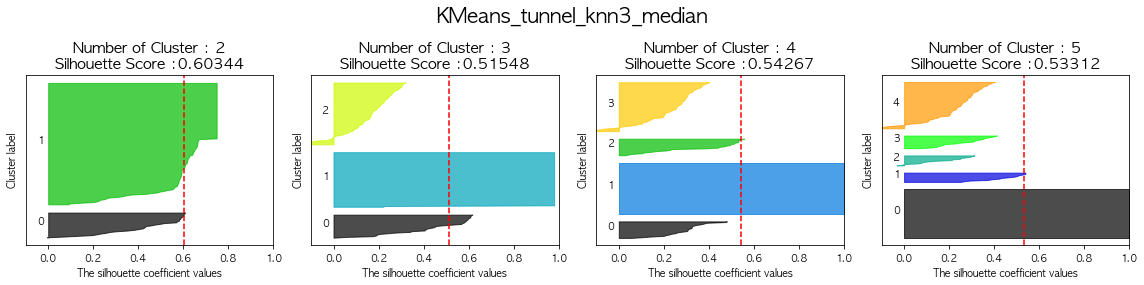

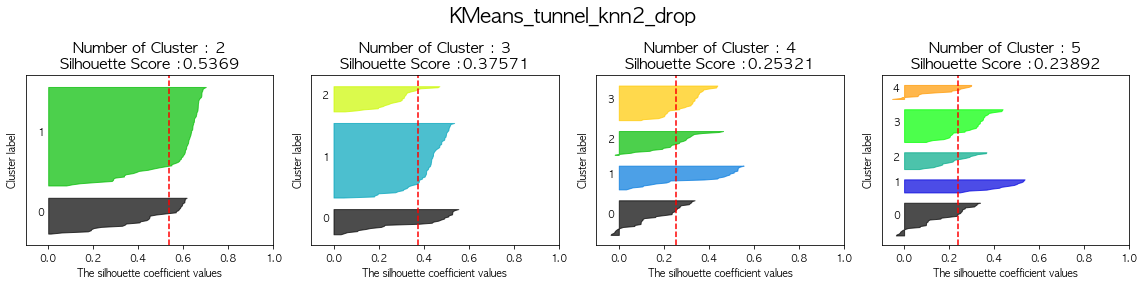

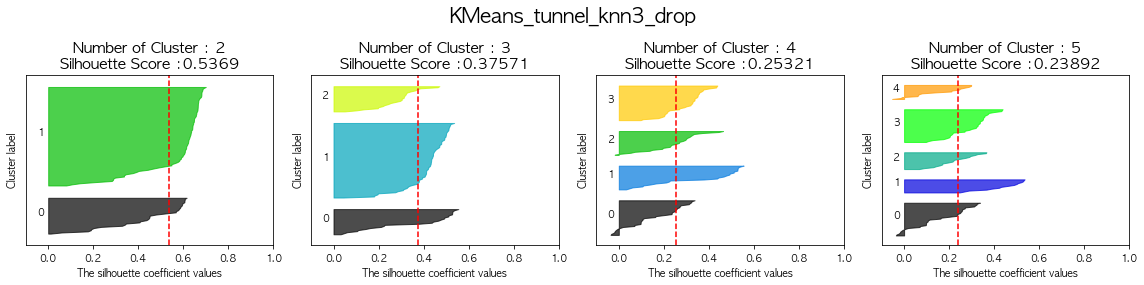

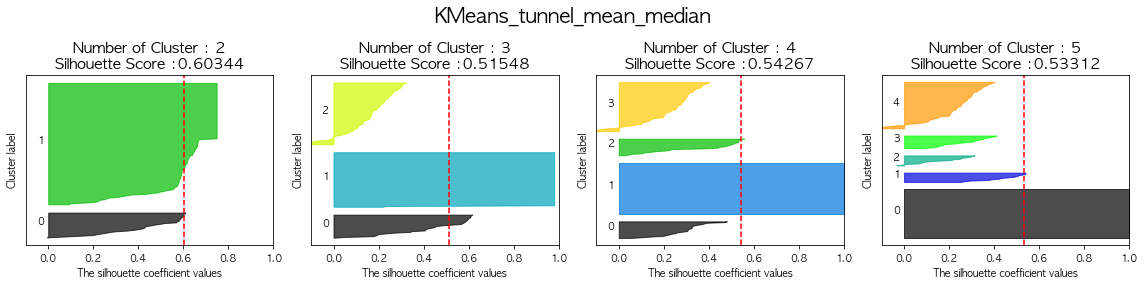

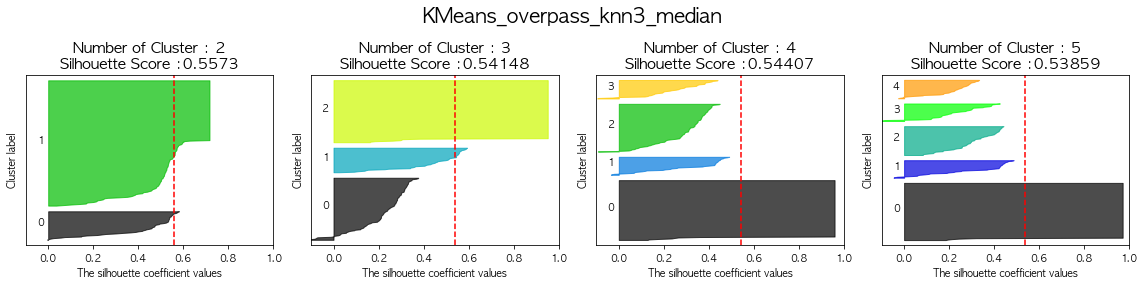

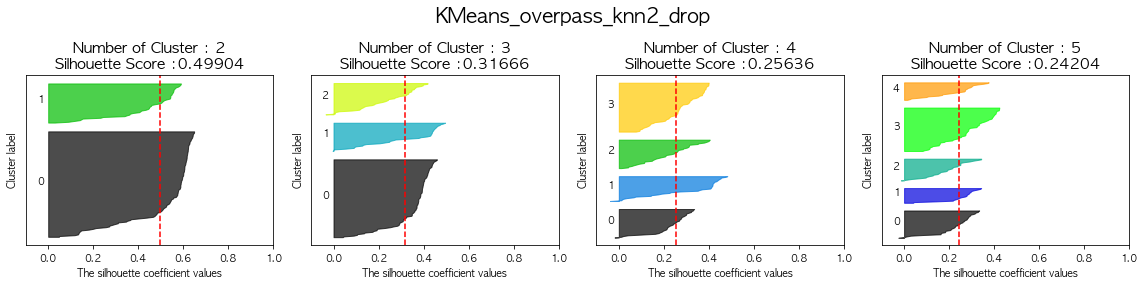

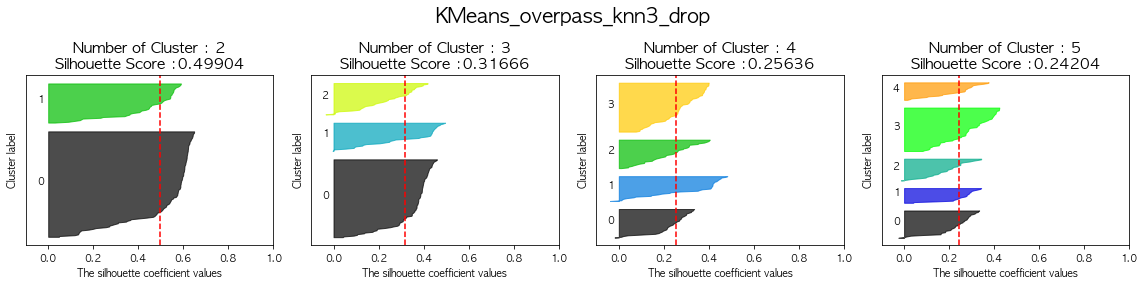

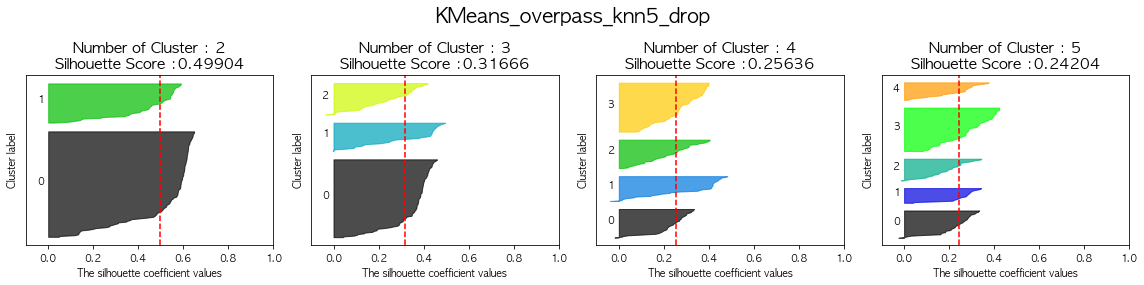

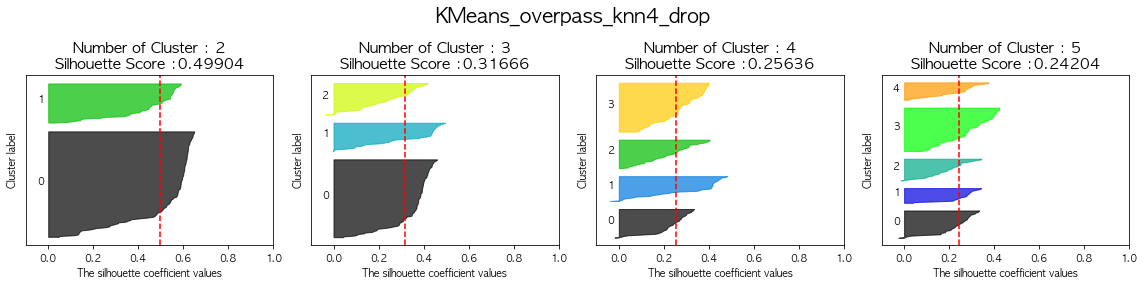

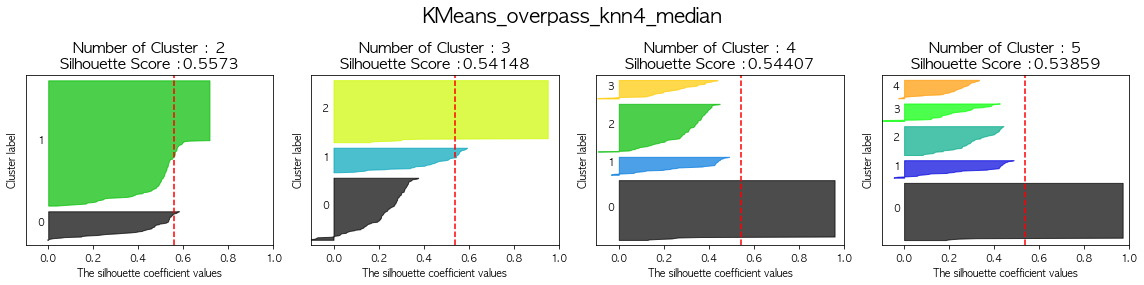

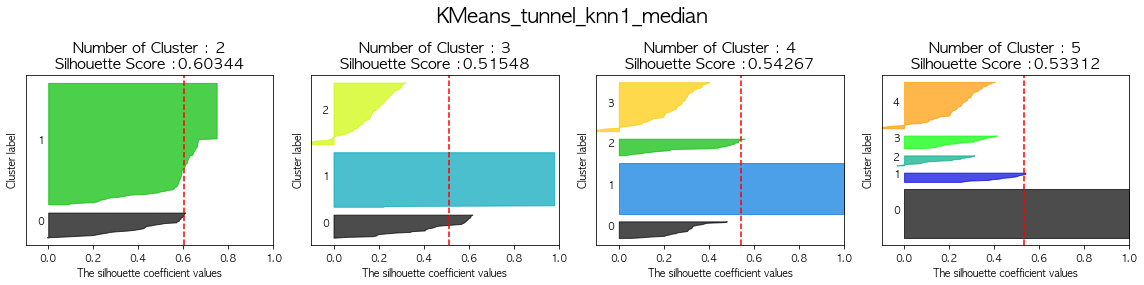

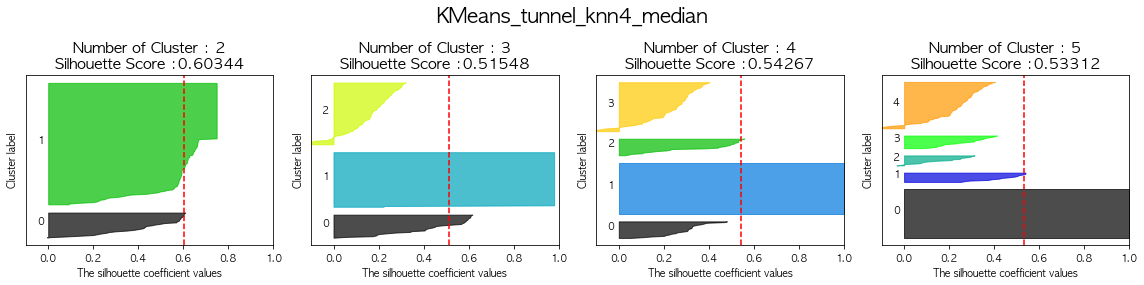

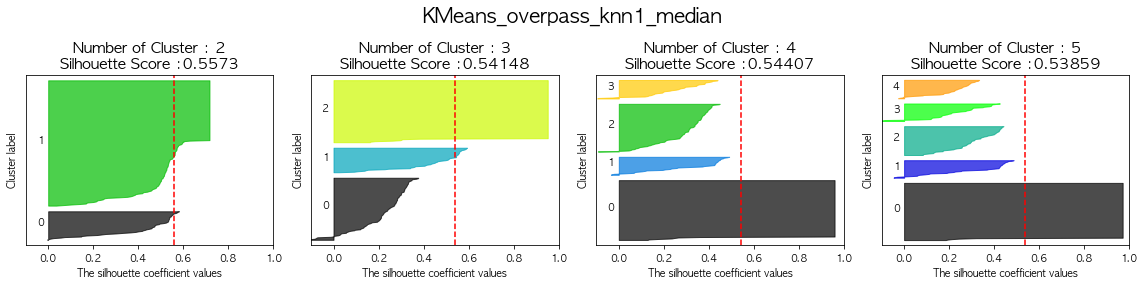

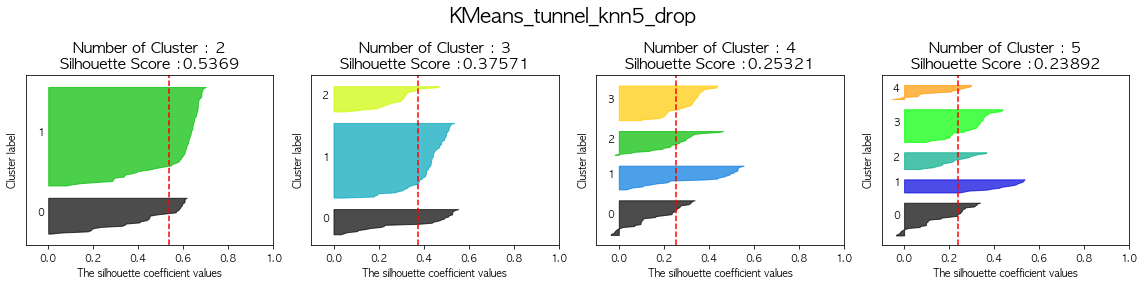

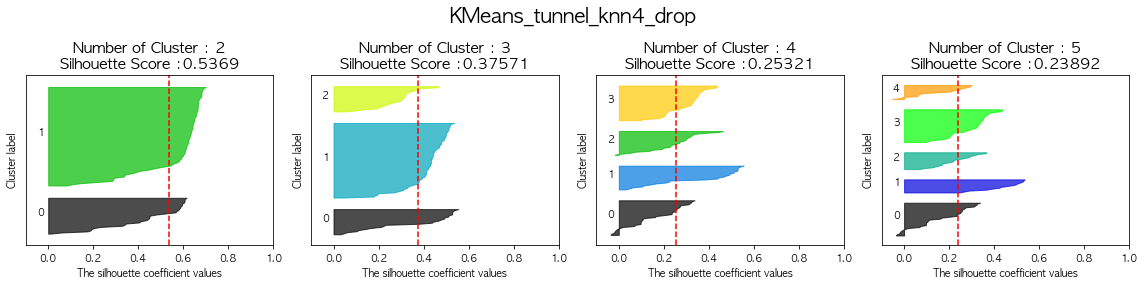

In [423]:
for idx, data in enumerate(data_list):
    visualize_silhouette([2, 3, 4, 5], data , idx)

/var/folders/x5/p0qmykj10d194mw60zsdt6fm0000gn/T/ipykernel_6205/4226666199.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize=(4 * num_cluster, 4), nrows = 1, ncols = num_cluster)


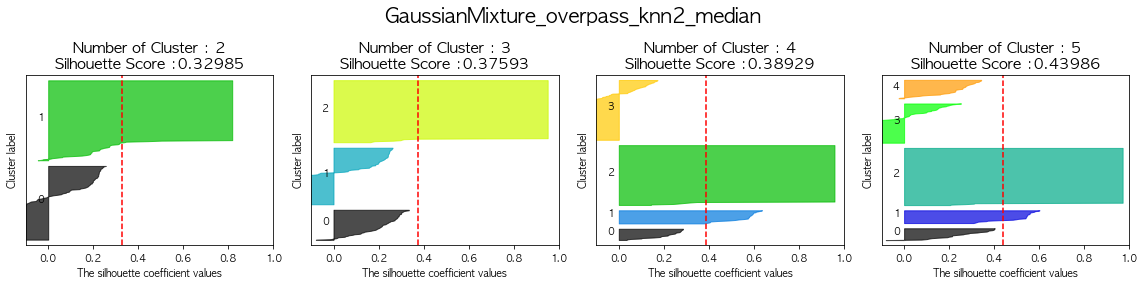

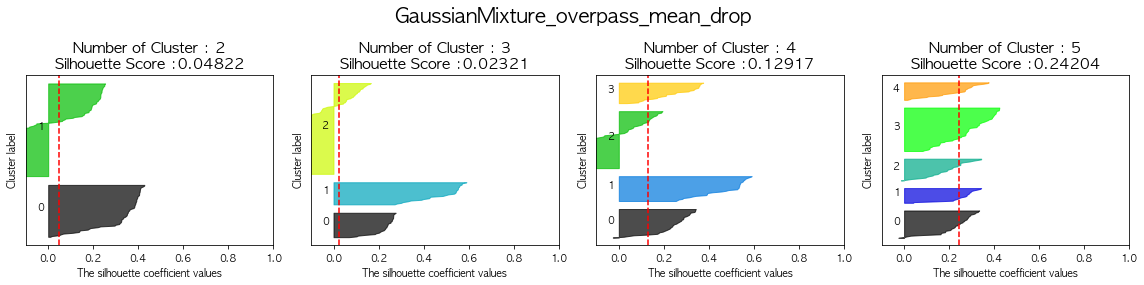

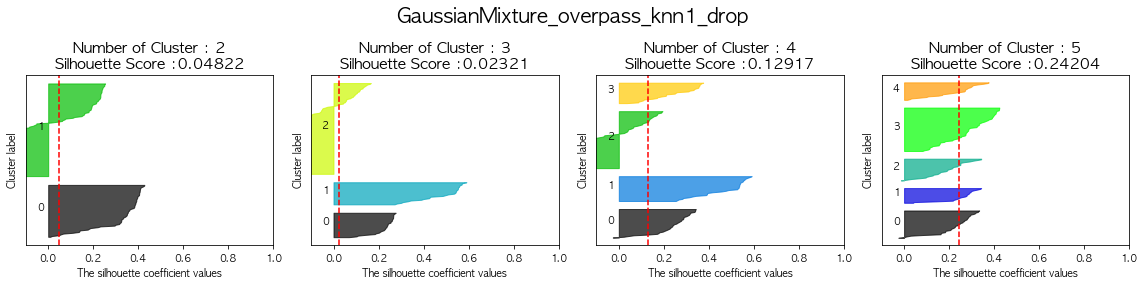

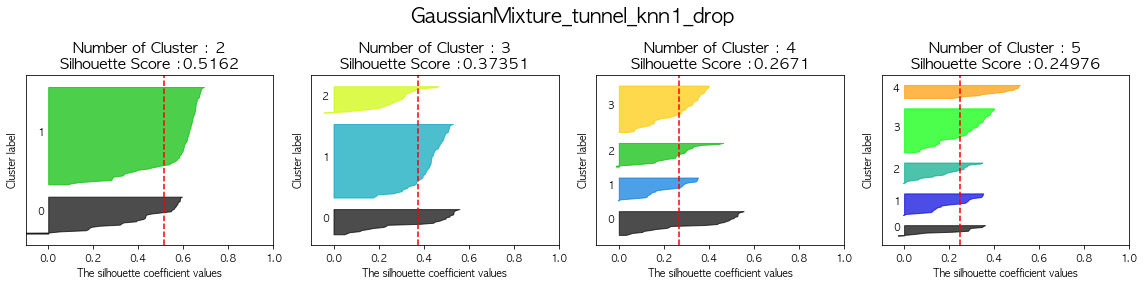

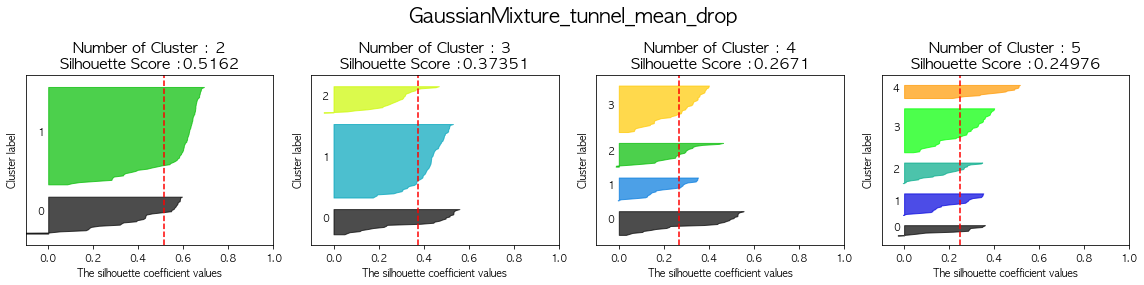

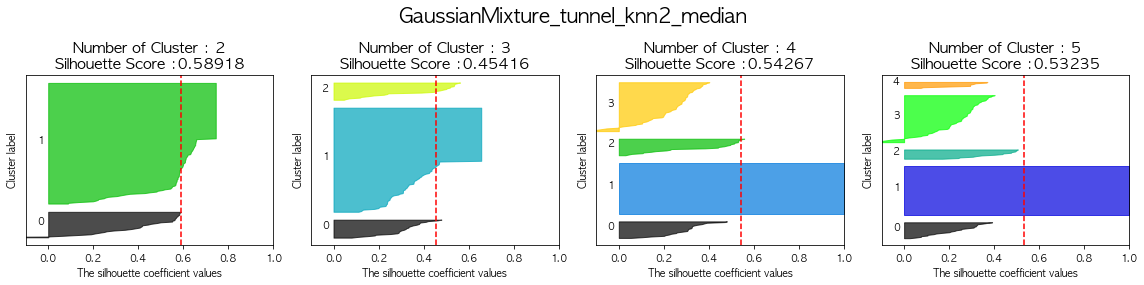

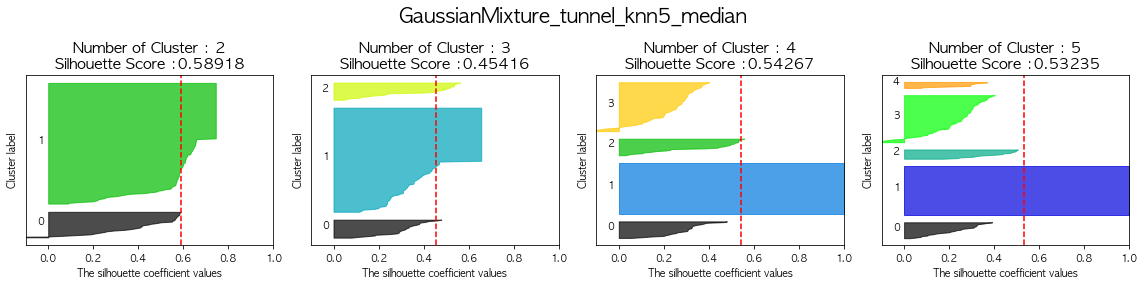

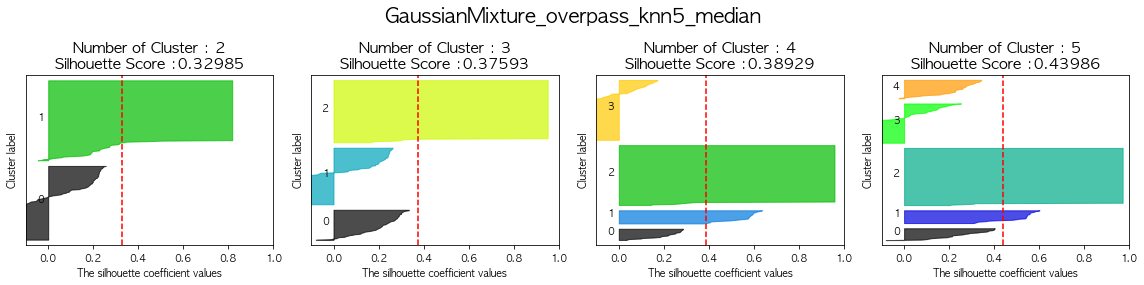

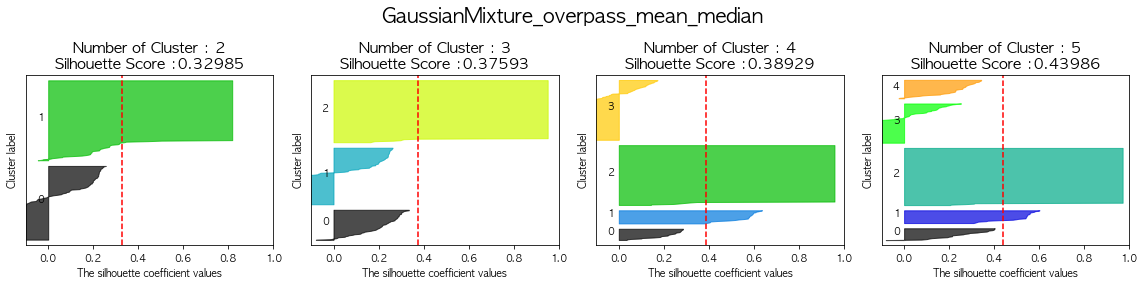

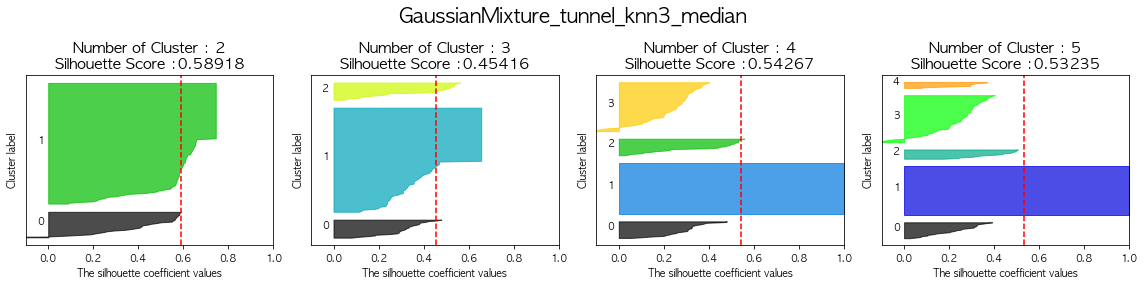

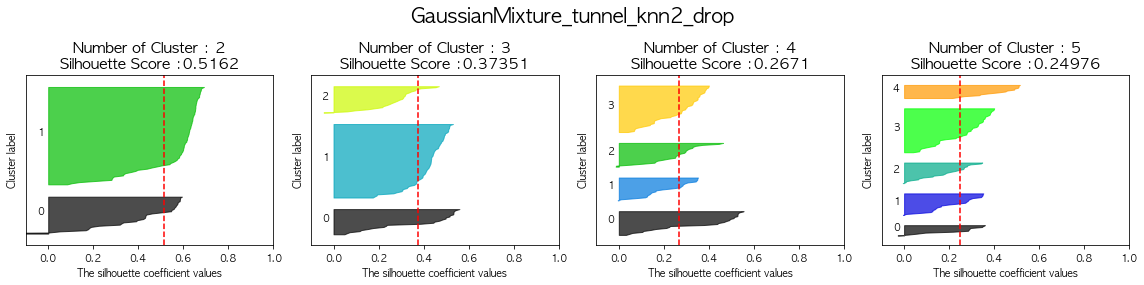

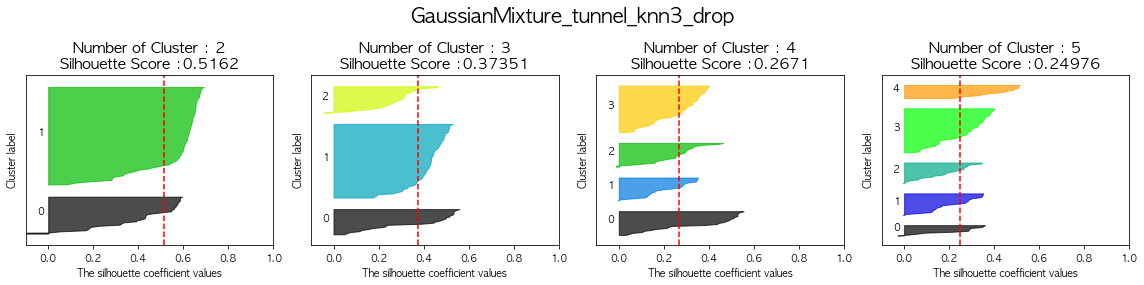

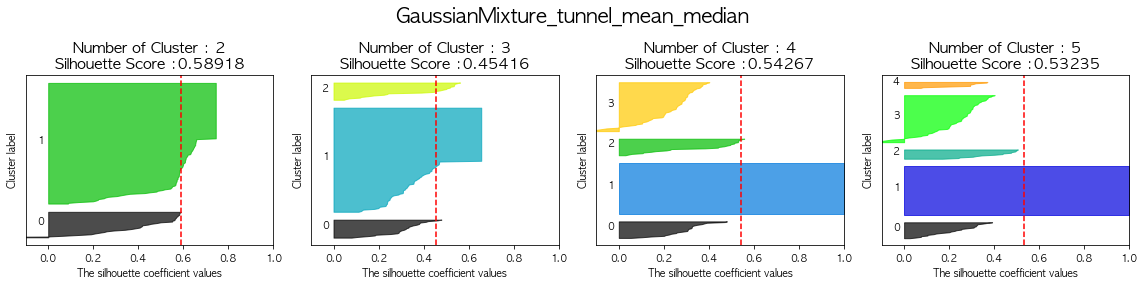

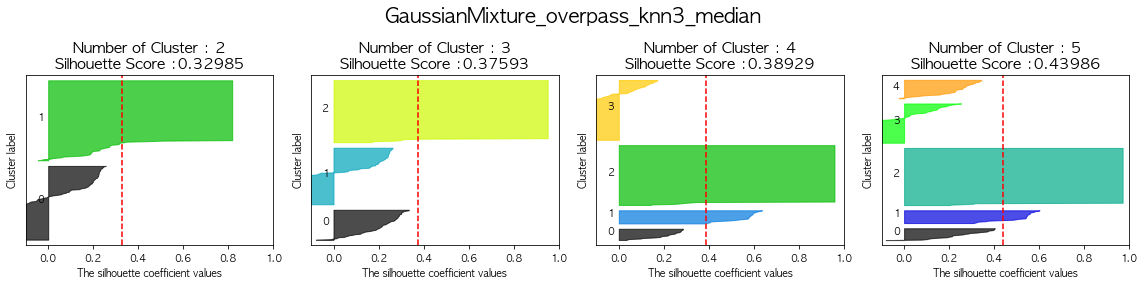

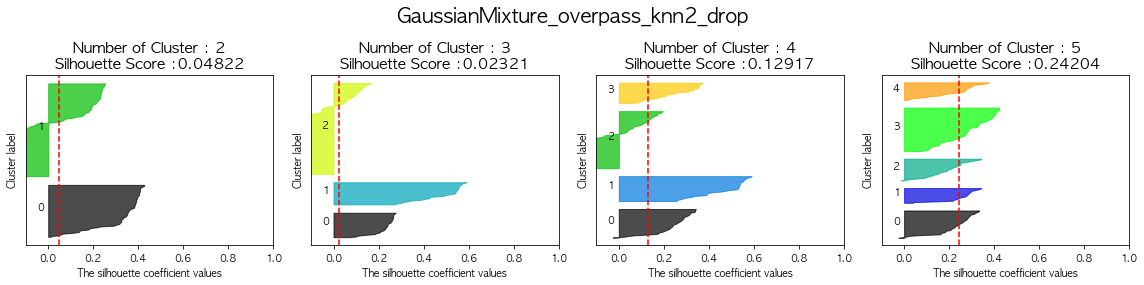

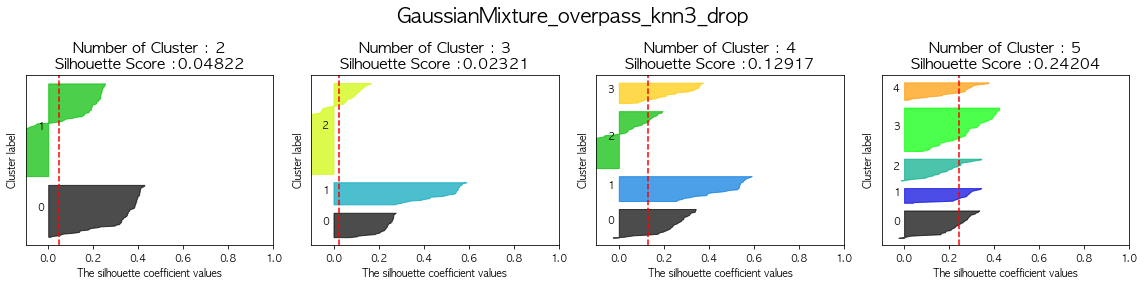

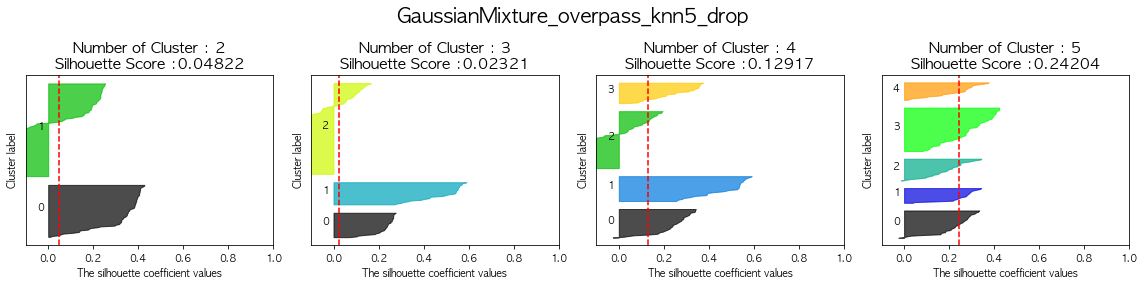

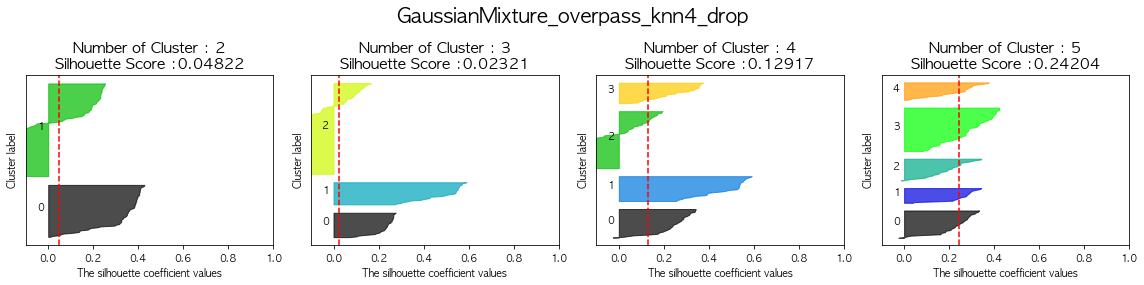

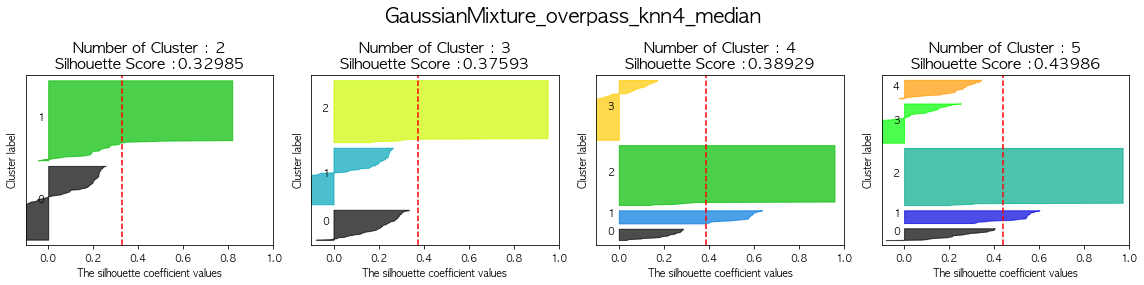

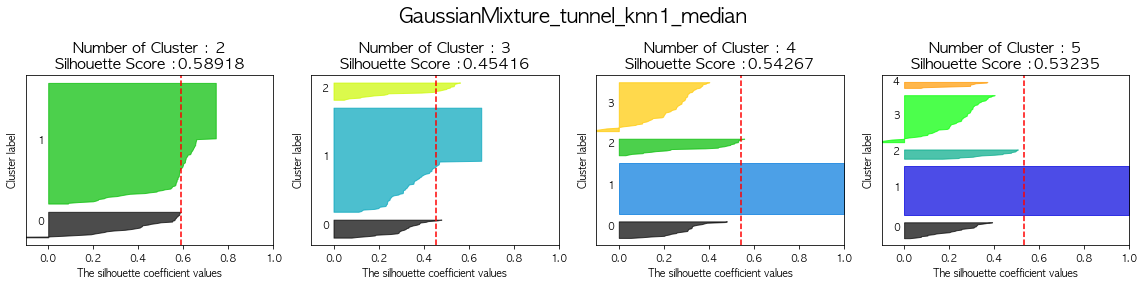

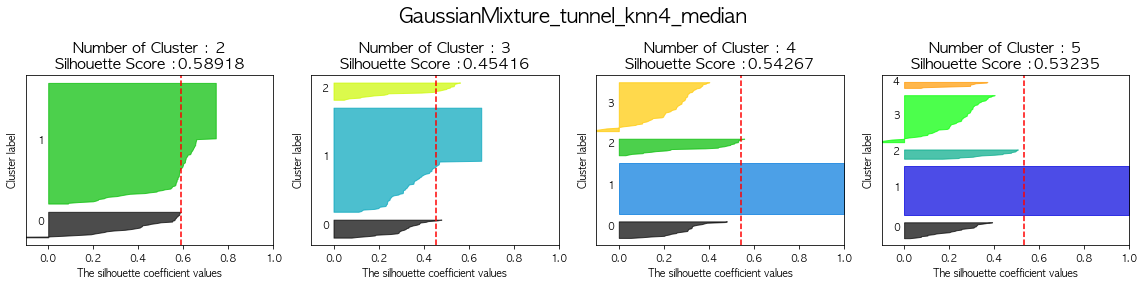

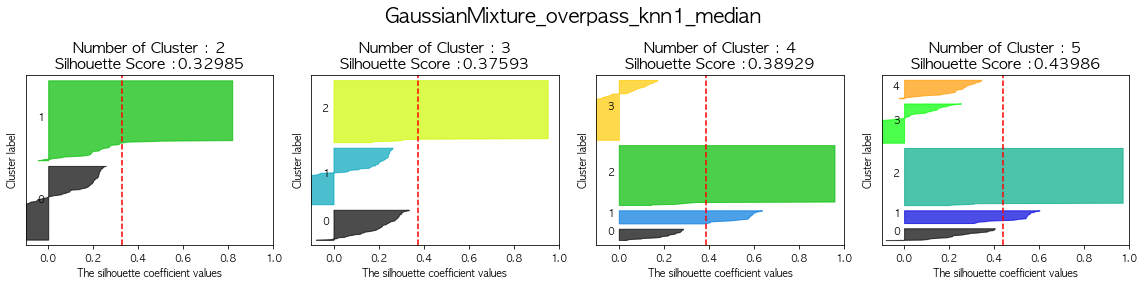

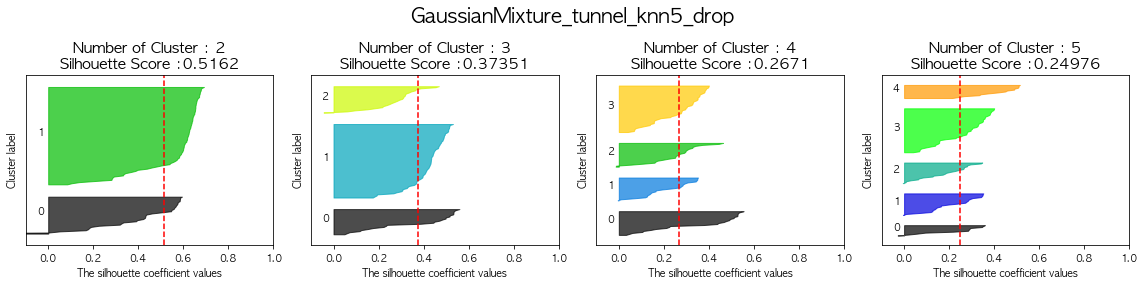

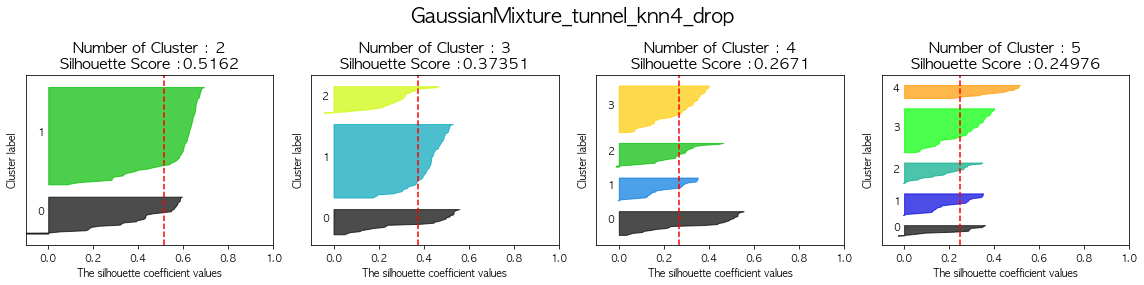

In [424]:
for idx, data in enumerate(data_list):
    visualize_silhouette([2, 3, 4, 5], data , idx, "GaussianMixture")

/var/folders/x5/p0qmykj10d194mw60zsdt6fm0000gn/T/ipykernel_6205/4226666199.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize=(4 * num_cluster, 4), nrows = 1, ncols = num_cluster)


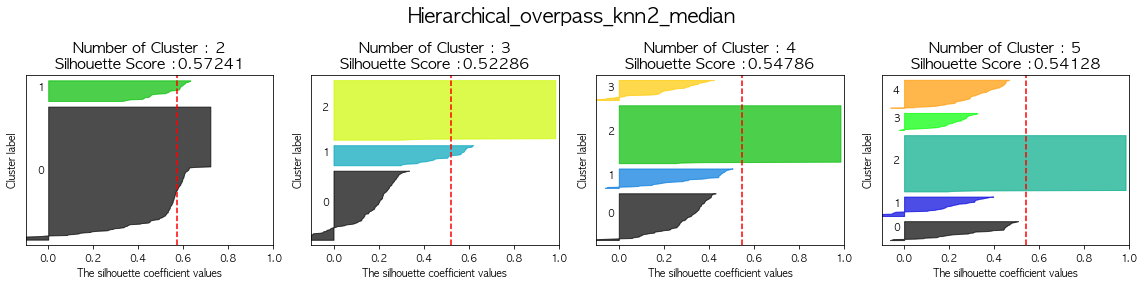

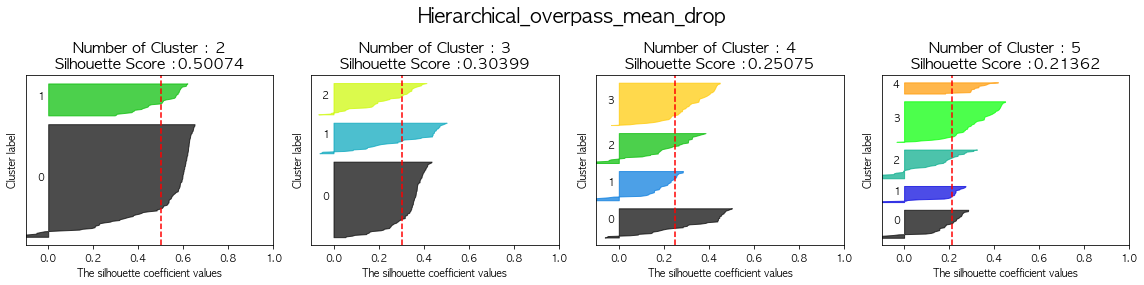

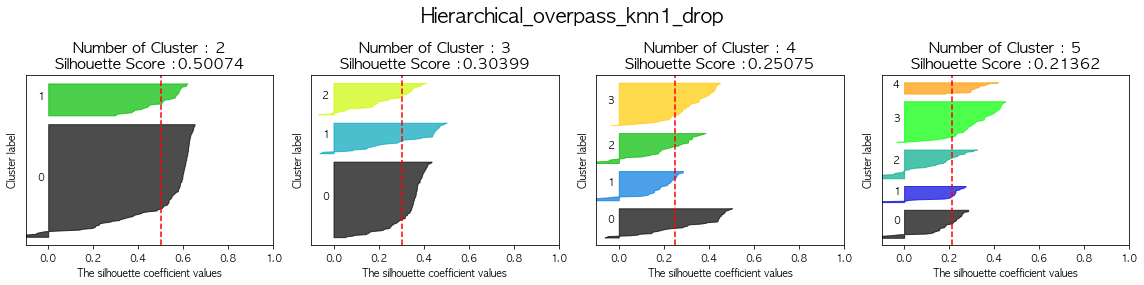

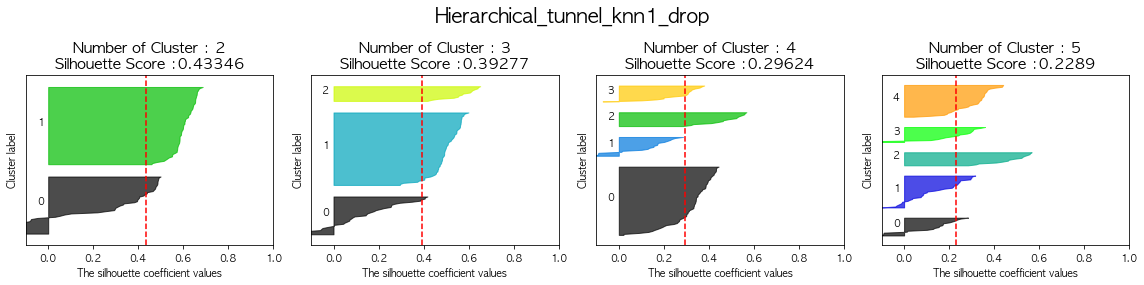

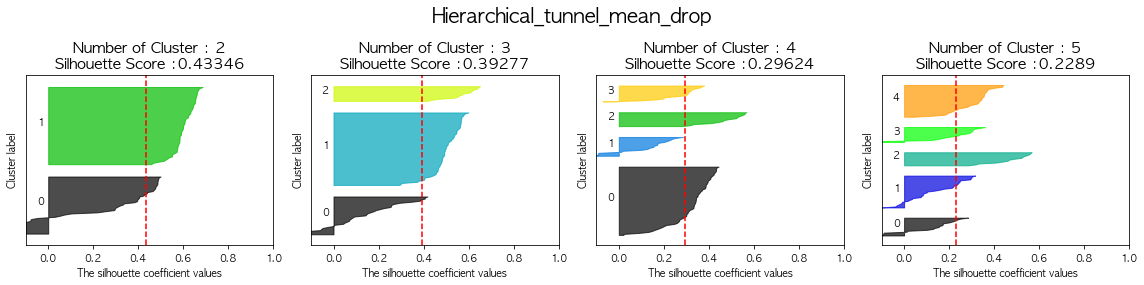

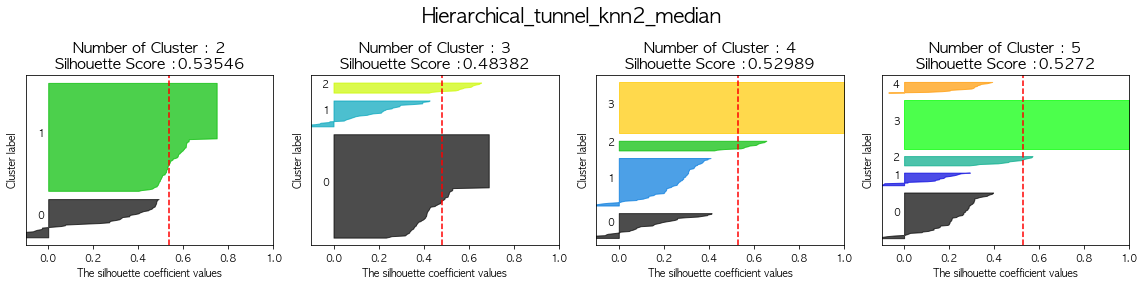

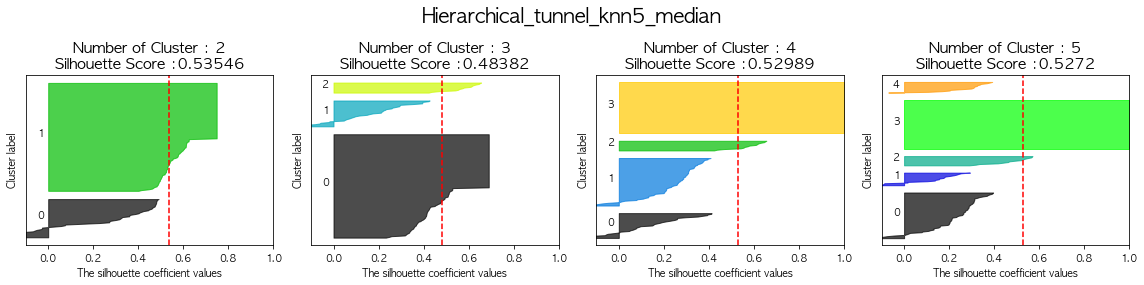

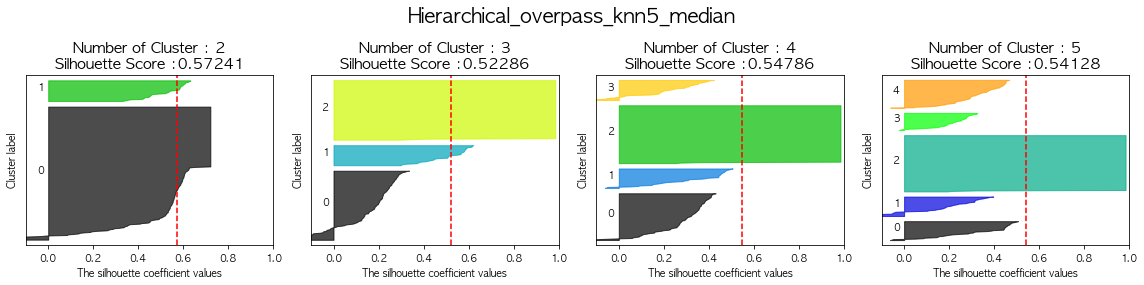

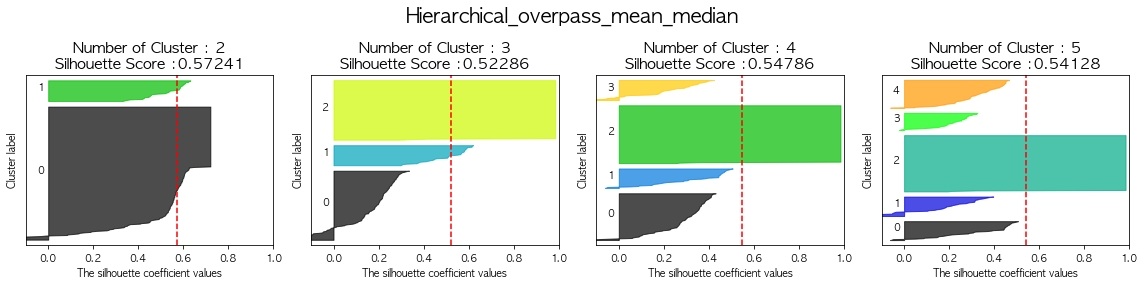

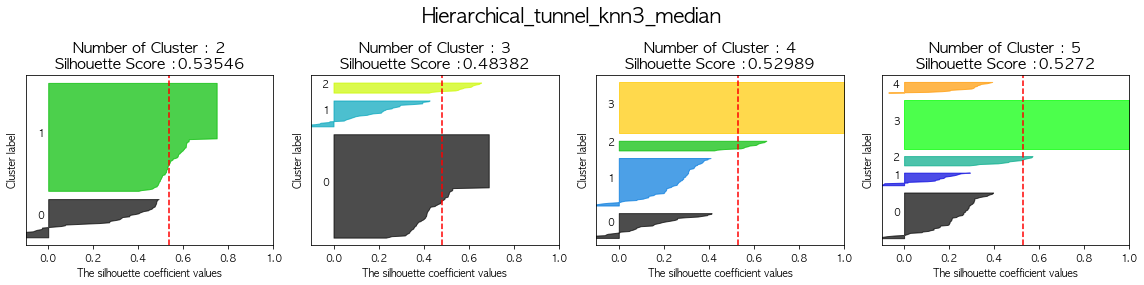

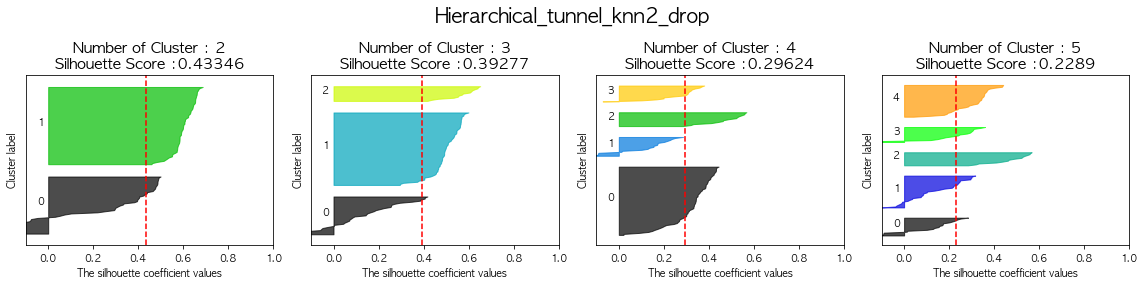

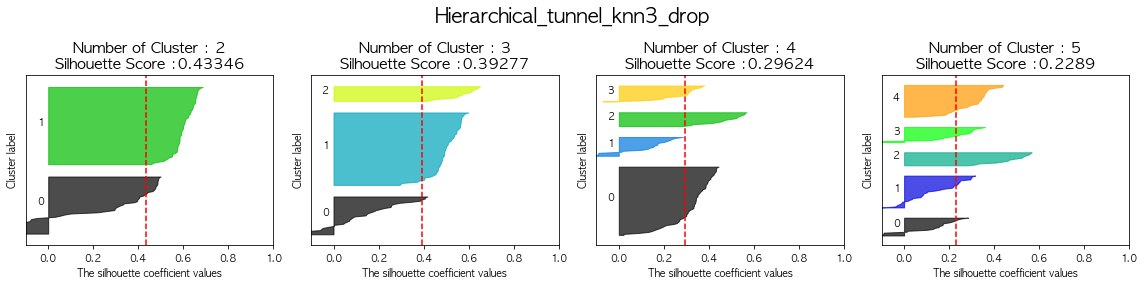

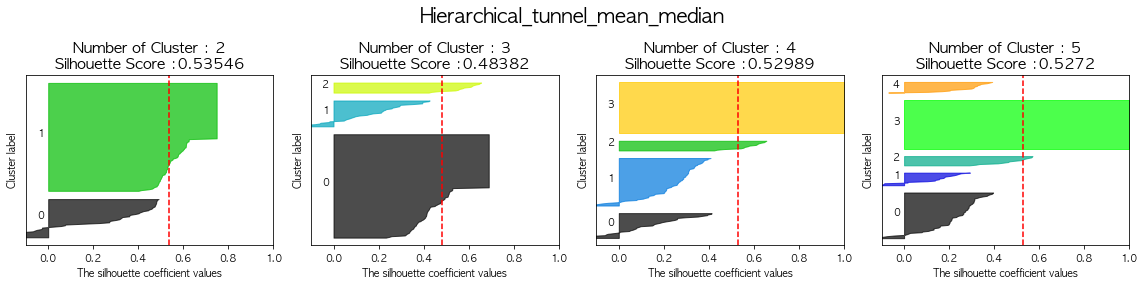

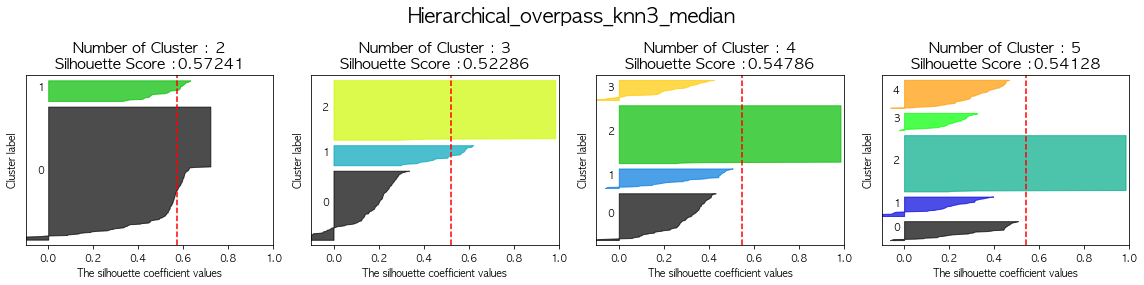

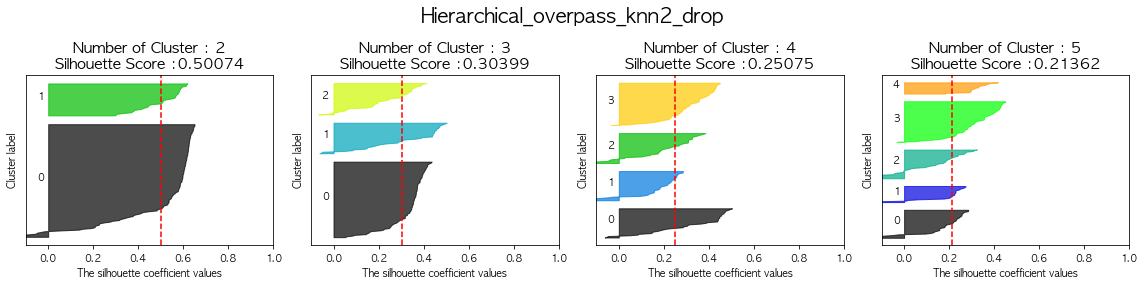

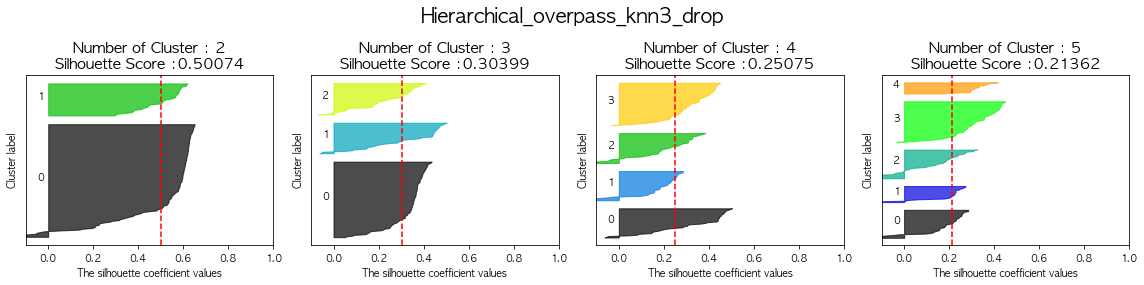

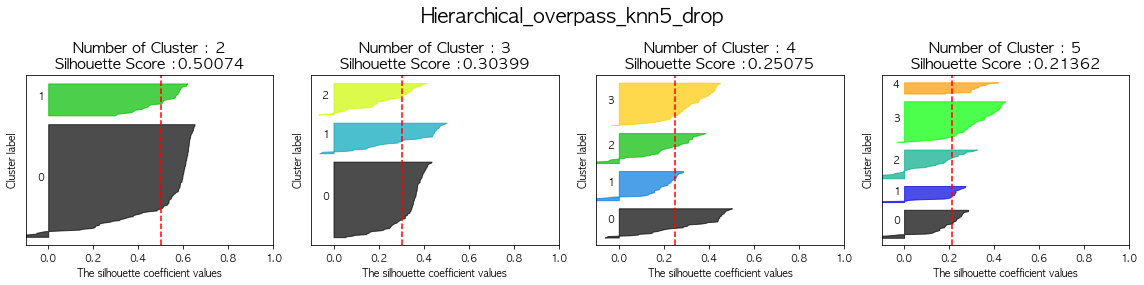

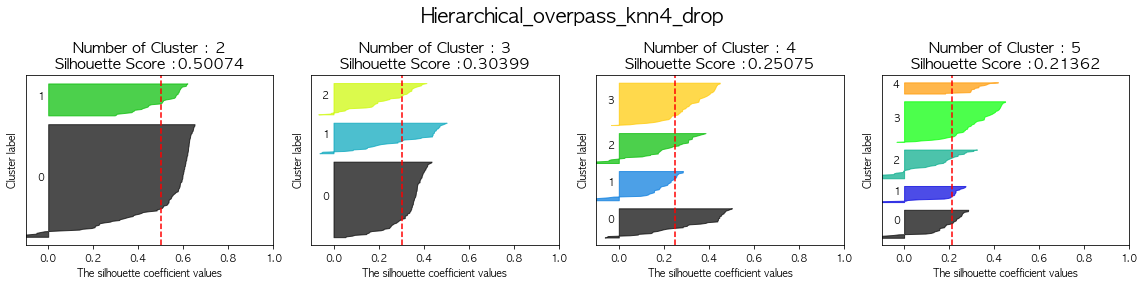

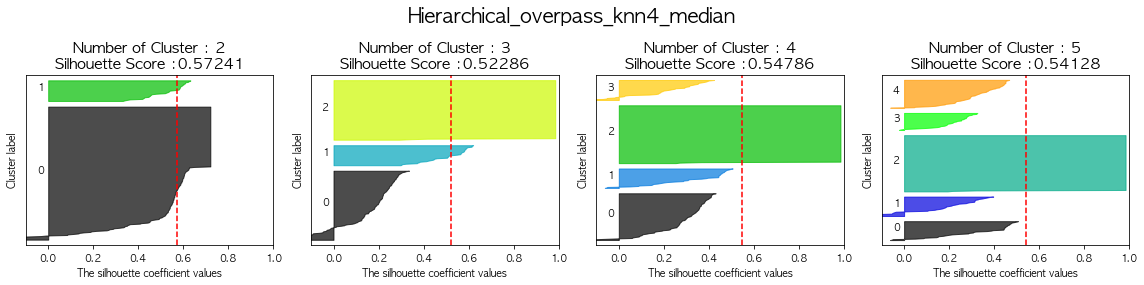

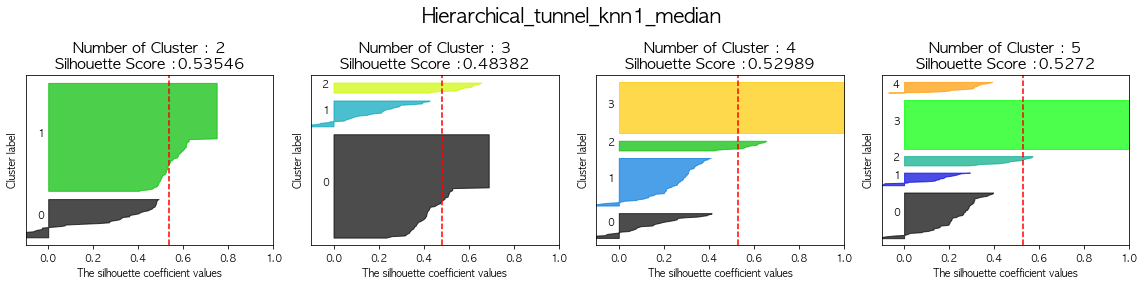

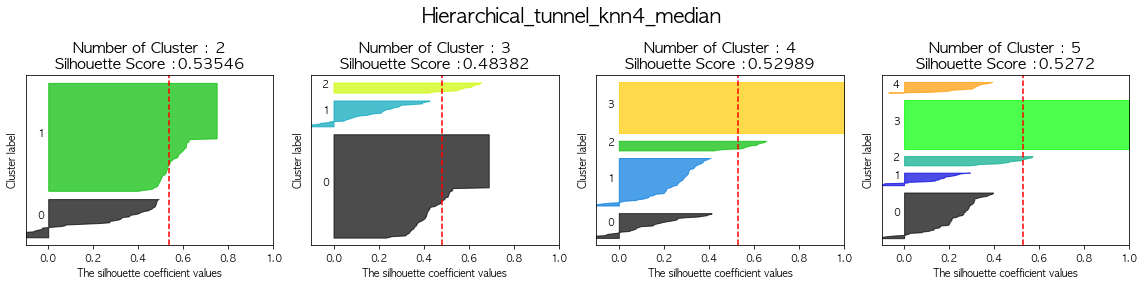

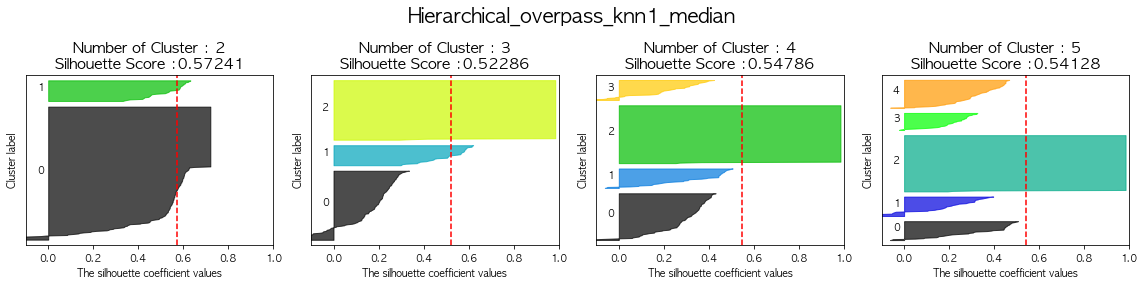

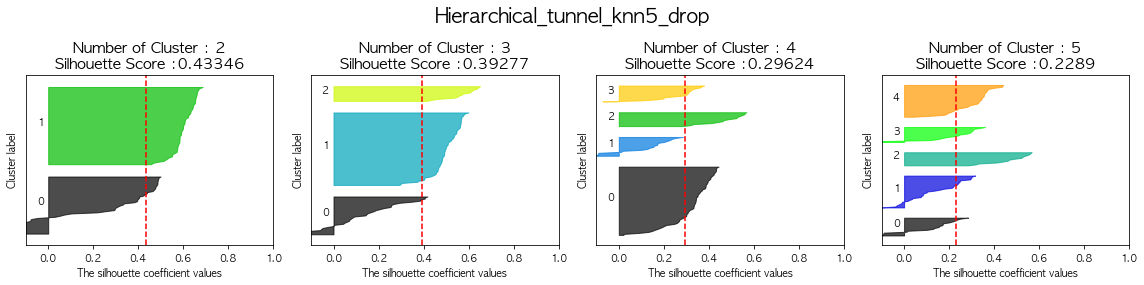

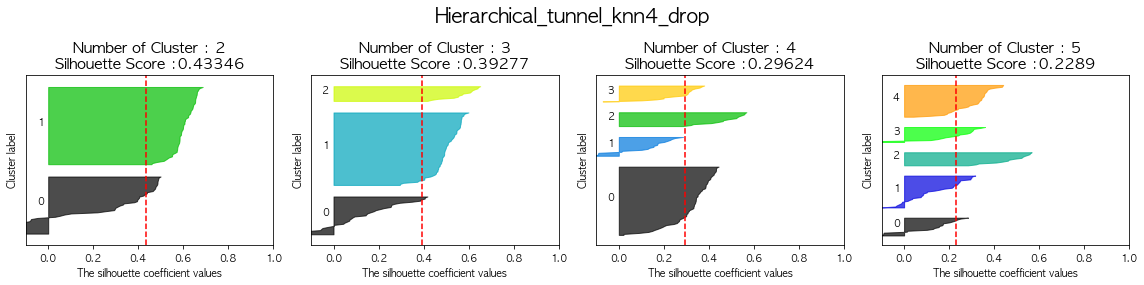

In [425]:
for idx, data in enumerate(data_list):
    visualize_silhouette([2, 3, 4, 5], data , idx, "Hierarchical")

/var/folders/x5/p0qmykj10d194mw60zsdt6fm0000gn/T/ipykernel_6205/4226666199.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize=(4 * num_cluster, 4), nrows = 1, ncols = num_cluster)


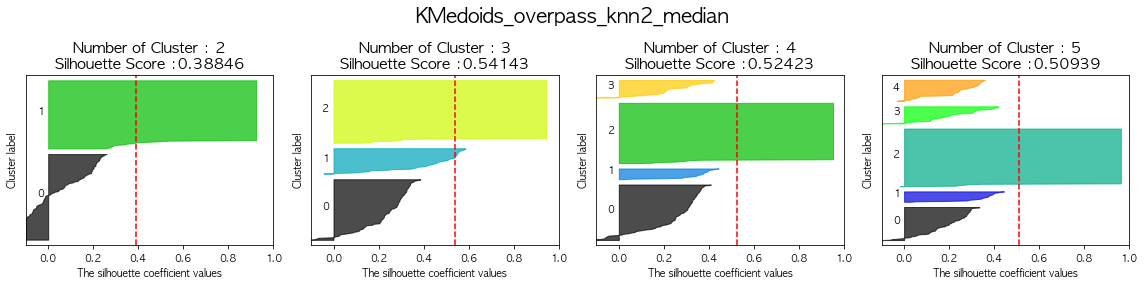

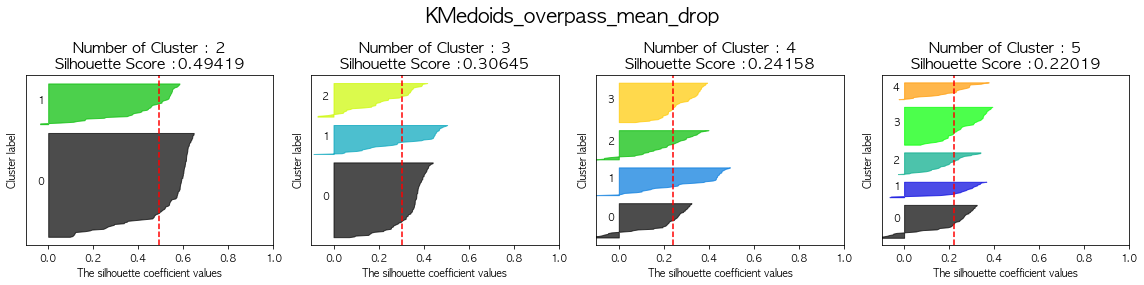

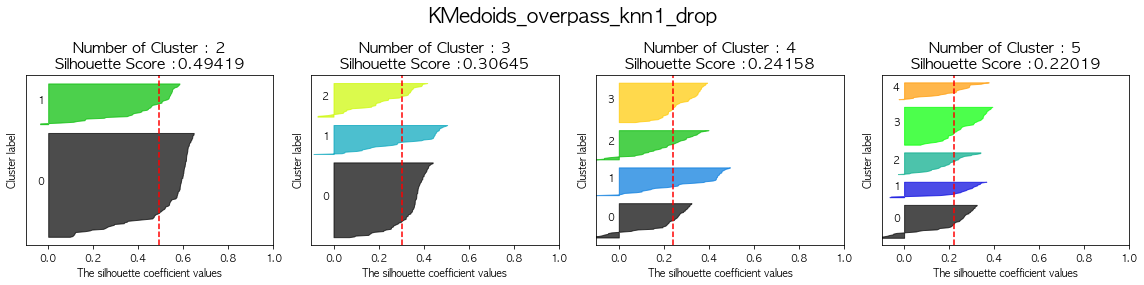

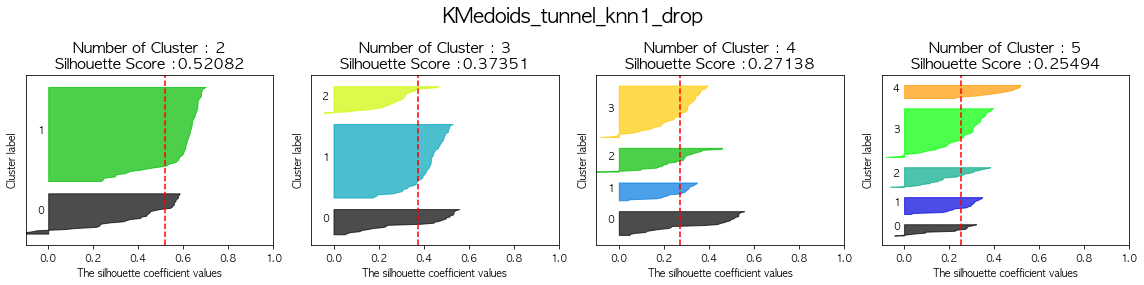

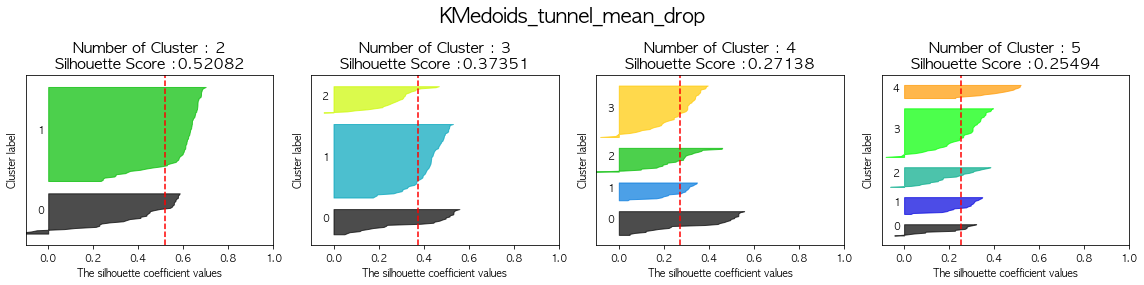

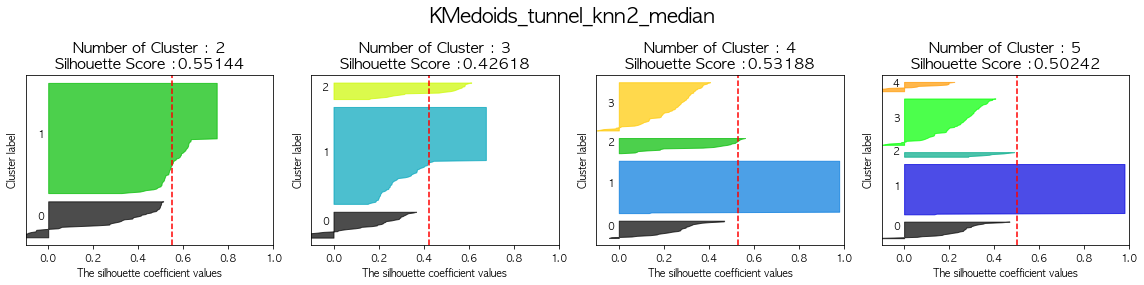

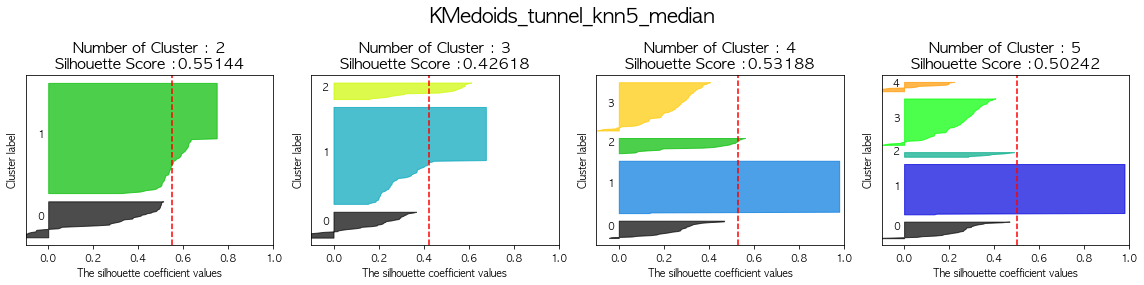

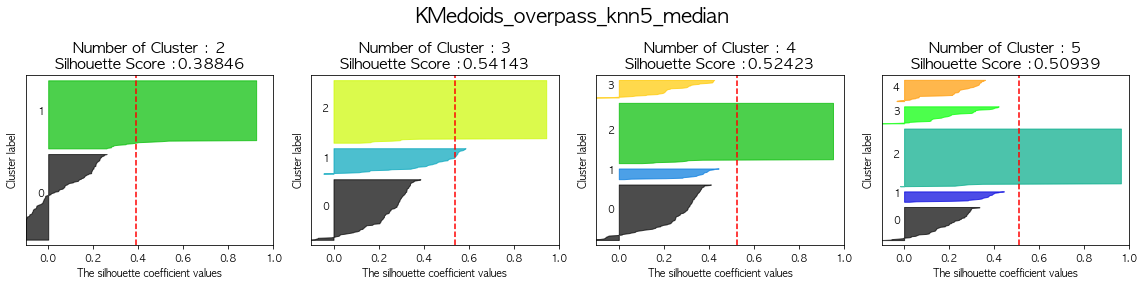

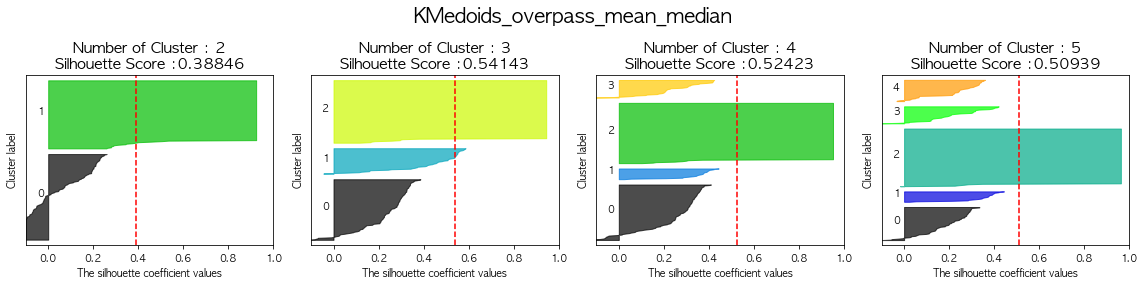

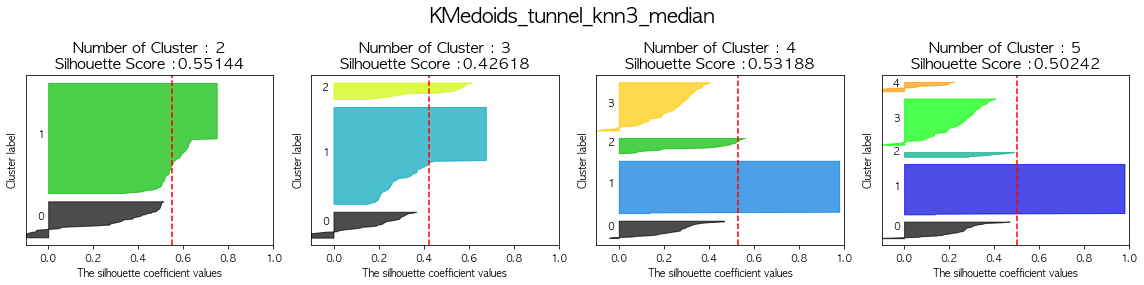

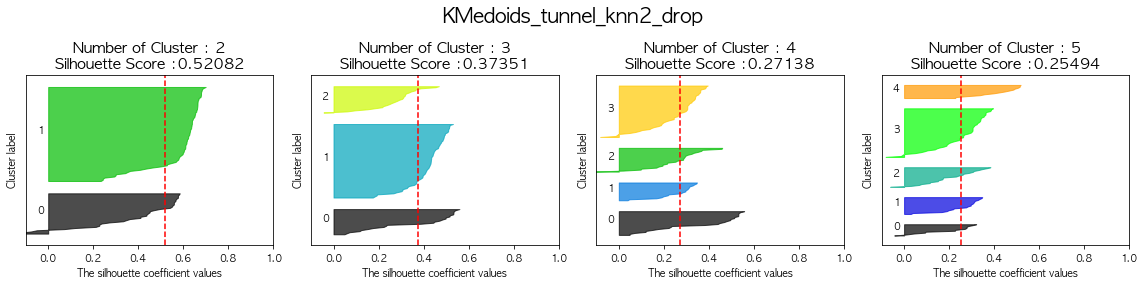

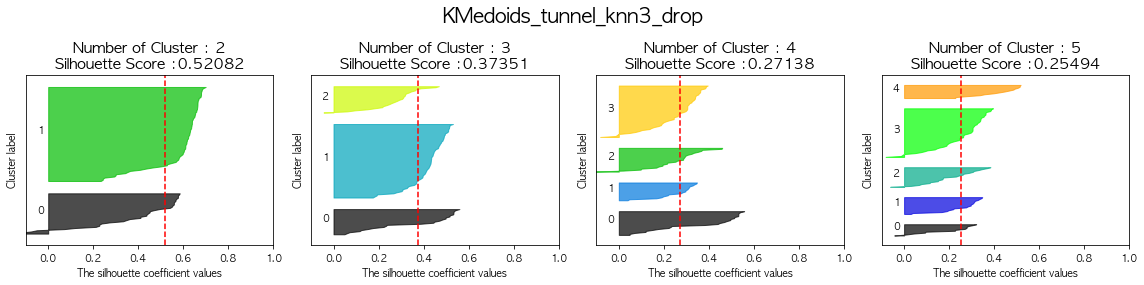

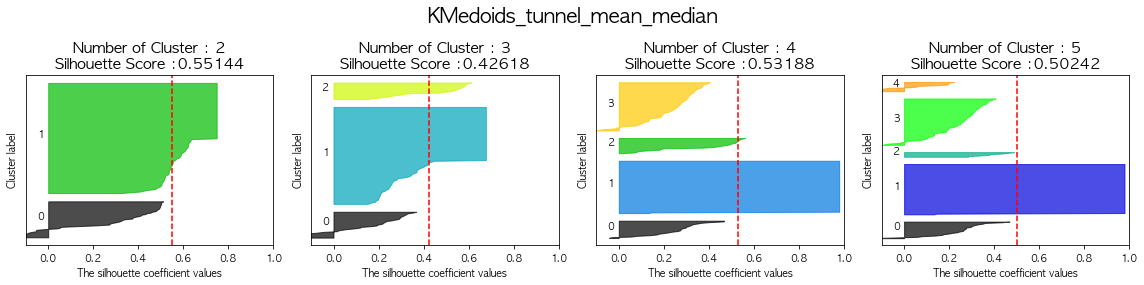

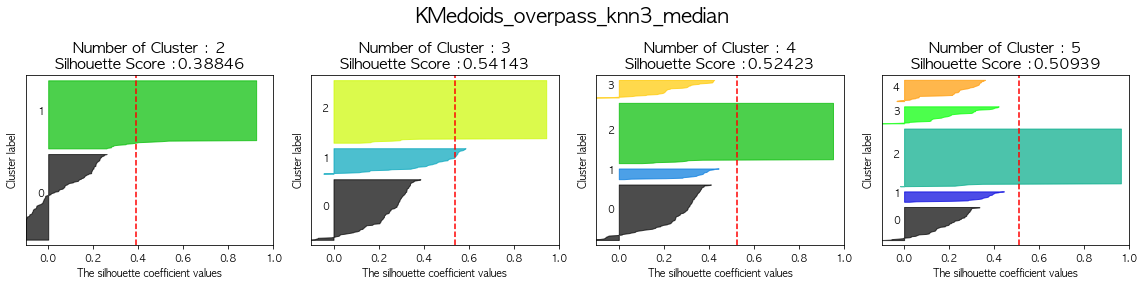

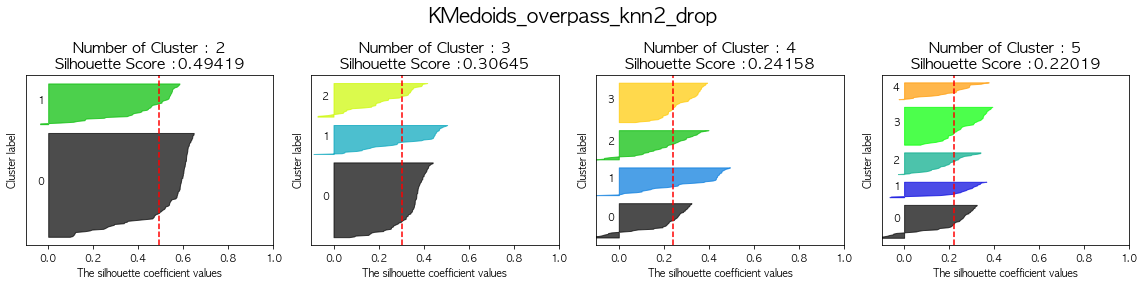

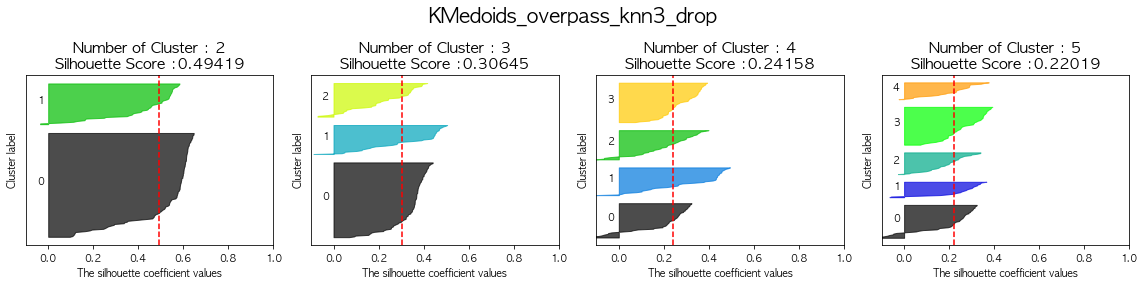

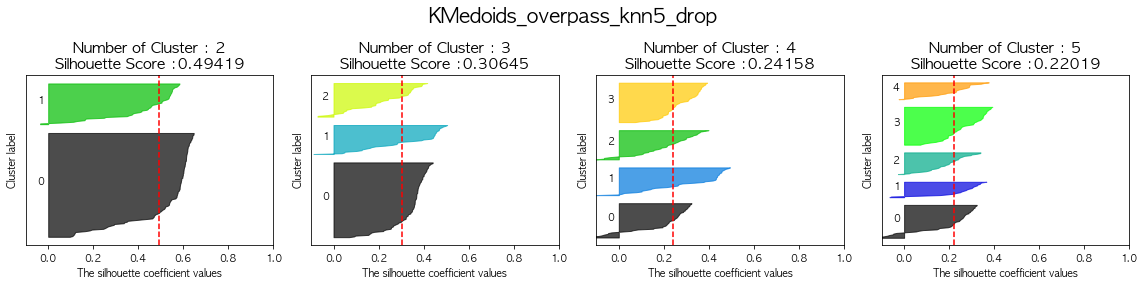

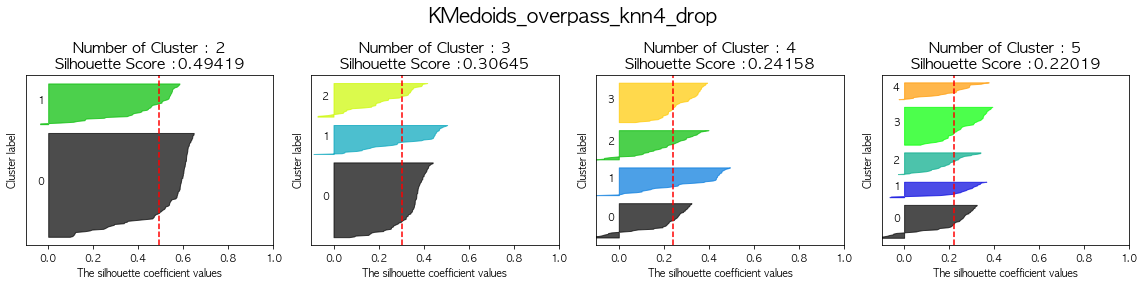

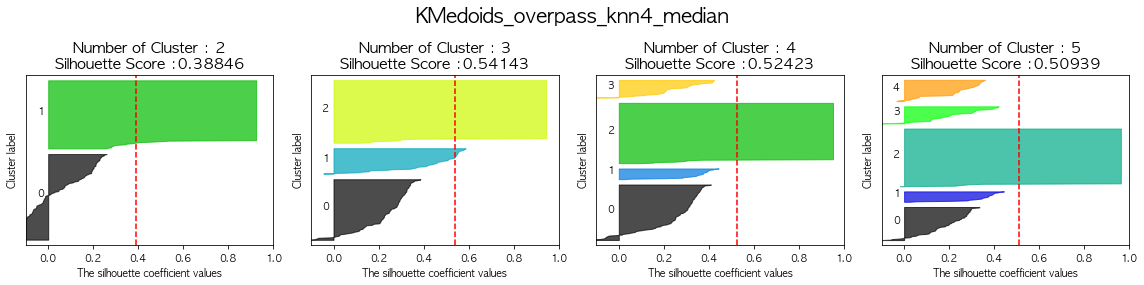

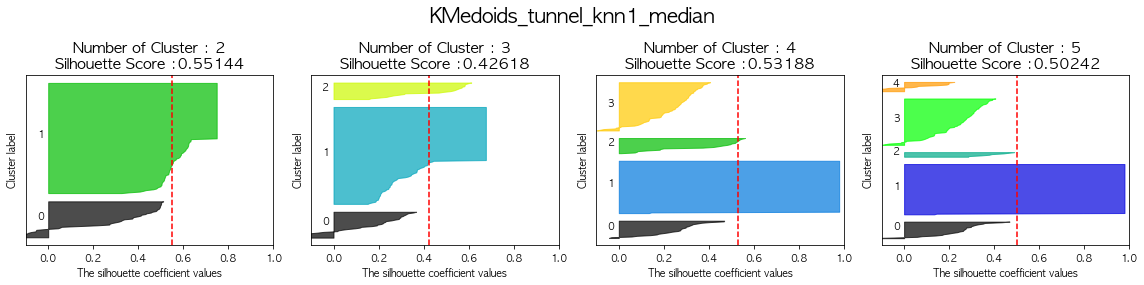

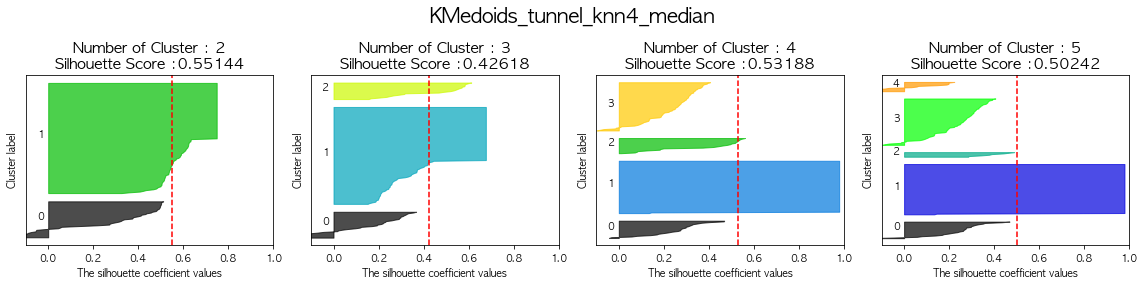

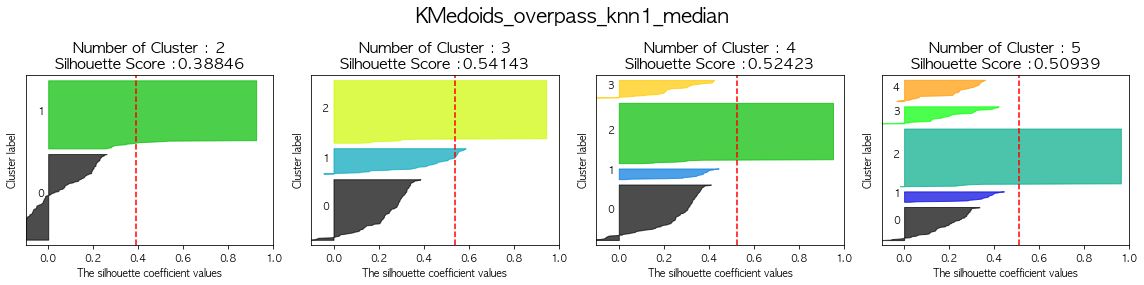

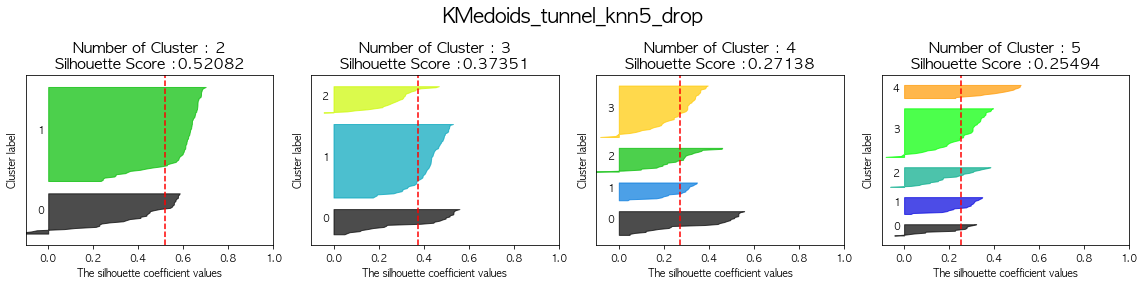

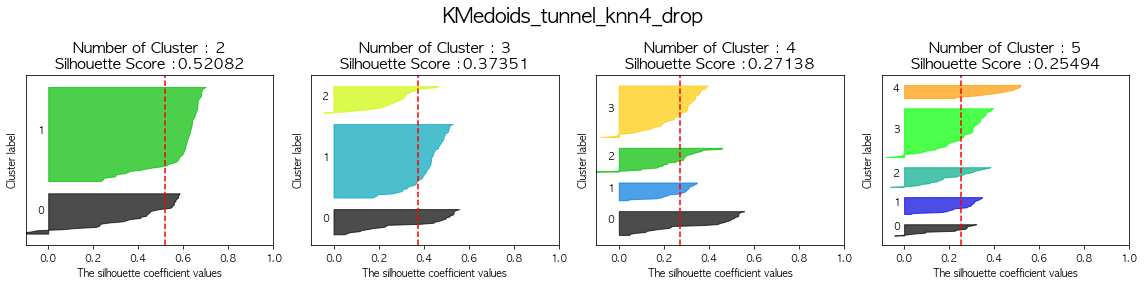

In [426]:
for idx, data in enumerate(data_list):
    visualize_silhouette([2, 3, 4, 5], data , idx, "KMedoids")